In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from xgboost import XGBClassifier

import random
import numpy as np
import torch

from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix
import numpy as np
import time

from torch.utils.data import Dataset, DataLoader, random_split


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/mnt/storageG1/lwang/miniconda3/envs/new-ml/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


Using device: cuda


In [2]:
# # Manual FASTA parsing (without Biopython)
# fasta_path = "../data//naturalAMPs_APD2024a-ADAM.fasta.txt"

# # Read lines from the FASTA file
# with open(fasta_path, "r") as f:
#     lines = f.read().strip().splitlines()

# # Parse into (ID, Sequence) pairs
# records = []
# current_id = None
# current_seq = []
# for line in lines:
#     if line.startswith(">"):
#         if current_id is not None:
#             records.append([current_id, ''.join(current_seq)])
#         current_id = line[1:].strip()
#         current_seq = []
#     else:
#         current_seq.append(line.strip())

# # Add the last record
# if current_id is not None:
#     records.append([current_id, ''.join(current_seq)])

# # Convert to DataFrame
# df_fasta_manual = pd.DataFrame(records, columns=["Peptide ID", "Sequence"])
# df_fasta_manual.to_csv("../data/naturalAMPs_APD2024a-ADAM.csv", index=False)


# Manual FASTA parsing (without Biopython)
# fasta_path = "../data/uniprotkb_length_10_TO_80_NOT_antimicro_2025_04_14.fasta"

# # Read lines from the FASTA file
# with open(fasta_path, "r") as f:
#     lines = f.read().strip().splitlines()

# # Parse into (ID, Sequence) pairs
# records = []
# current_id = None
# current_seq = []
# for line in lines:
#     if line.startswith(">"):
#         if current_id is not None:
#             records.append([current_id, ''.join(current_seq)])
#         current_id = line[1:].strip()
#         current_seq = []
#     else:
#         current_seq.append(line.strip())

# # Add the last record
# if current_id is not None:
#     records.append([current_id, ''.join(current_seq)])

# # Convert to DataFrame
# df_fasta_manual = pd.DataFrame(records, columns=["Peptide ID", "Sequence"])
# df_fasta_manual.to_csv("../data/uniprotkb_length_10_TO_80_NOT_antimicro_2025_04_14.fasta.csv", index=False)



# fasta_path = "../data/uniprotkb_length_5_TO_30_NOT_antimicrob_2025_04_14.fasta (1)"

# # Read lines from the FASTA file
# with open(fasta_path, "r") as f:
#     lines = f.read().strip().splitlines()

# # Parse into (ID, Sequence) pairs
# records = []
# current_id = None
# current_seq = []
# for line in lines:
#     if line.startswith(">"):
#         if current_id is not None:
#             records.append([current_id, ''.join(current_seq)])
#         current_id = line[1:].strip()
#         current_seq = []
#     else:
#         current_seq.append(line.strip())

# # Add the last record
# if current_id is not None:
#     records.append([current_id, ''.join(current_seq)])

# # Convert to DataFrame
# df_fasta_manual = pd.DataFrame(records, columns=["Peptide ID", "Sequence"])
# df_fasta_manual.to_csv("../data/uniprotkb_length_10_TO_80_NOT_antimicro_2025_04_14.fasta1.csv", index=False)

## Data

In [ ]:
from Bio import SeqIO

def read_fasta_sequences(fasta_path):
    """
    Reads sequences from a FASTA file and returns them as a list of strings.

    Args:
        fasta_path (str): Path to the FASTA file.

    Returns:
        List[str]: A list of amino acid or nucleotide sequences as strings.
    """
    sequences = [str(record.seq) for record in SeqIO.parse(fasta_path, "fasta")]
    return sequences

In [ ]:
dbbasp = pd.read_csv("../models1/database_check/DBAASP_peptides.csv")
dbbasp = dbbasp[["ID", "SEQUENCE"]]
dbbasp.columns = ["Peptide ID", "Sequence"]
adam_df = pd.read_csv("../data/naturalAMPs_APD2024a-ADAM.csv")
adam_df = pd.concat([adam_df, dbbasp], ignore_index=True)
uniprot_df = pd.read_csv("../data/uniprotkb_length_10_TO_80_NOT_antimicro_2025_04_14.fasta.csv")
uniprot_df1 = pd.read_csv("../data/uniprotkb_length_10_TO_80_NOT_antimicro_2025_04_14.fasta1.csv")
uniprot_df2 = pd.read_csv("/mnt/storageG1/lwang/Projects/TB-AMP-design/data/uniprotkb_length_5_TO_30_NOT_antimicrob_2025_04_23 (1).tsv", sep="\t")
uniprot_df2
uniprot_df2 = uniprot_df2[['Entry', 'Sequence']]
uniprot_df2.columns = ["Peptide ID", "Sequence"]
uniprot_df = pd.concat([uniprot_df, uniprot_df1, uniprot_df2], ignore_index=True)

In [29]:
uniprot_df = uniprot_df[uniprot_df['Sequence'].apply(lambda s: isinstance(s, str) and len(s) >= 10)]
uniprot_df = uniprot_df.drop_duplicates(subset="Sequence")
uniprot_df

,Peptide ID,Sequence
0,tr|A0A009HCC0|A0A009HCC0_9GAMM Acyl carrier pr...,MSDIEQRVKQAVAEQLGLKAEEIKNEASFMDDLGADSLDLVELVMS...
6,tr|A0A009YF97|A0A009YF97_9GAMM Acyl carrier pr...,MSDIEQRVKQAVAEQLGMKVEEIKNEASFMDDLGADSLDLVELVMS...
8,tr|A0A010SZ96|A0A010SZ96_PSEFL Acyl carrier pr...,MSTIEERVKKIVAEQLGVKEEEVVNTASFVEDLGADSLDTVELVMA...
9,tr|A0A011NAB1|A0A011NAB1_9PAST Acyl carrier pr...,MSIEERVKKIIVDQLGAKAEDVKPEASFIEDLGADSLDTVELVMAL...
10,tr|A0A011NTH9|A0A011NTH9_9PROT DNA-directed RN...,MARVTVDDCLTRIPNRFQMTLAATYRARQITAGASPLIDANRDKPT...
...,...,...
104968,P9WEJ1,MPEQKANCSPNGNITVDSMIMSLGSS
105566,Q6LEB3,LFNKYISRPRRVELAVMLNLTERHIKI
105568,Q6QLL8,VKGFSFKYGNGVWIGRTKSTNSRSGFQ
105789,Q9DTV7,HFPGFGQSLLFGYPVYVFGDCVQGDWCR


In [30]:

# Remove rows where the Sequence is not a string or is shorter than 10 characters
adam_df = adam_df[adam_df['Sequence'].apply(lambda x: isinstance(x, str) and len(x) >= 10)]

190 10
Range of sequence lengths: 180


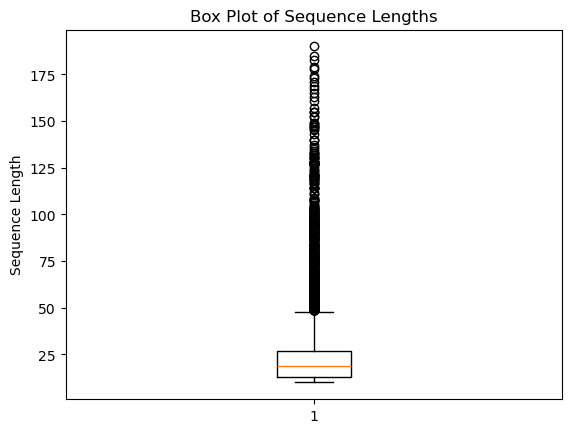

Mean sequence length: 23.250698890792677
Median sequence length: 19.0
Standard deviation of sequence lengths: 15.501457216027081


In [31]:
import matplotlib.pyplot as plt

# Calculate sequence lengths
sequence_lengths = adam_df['Sequence'].apply(len)

# Calculate the range of sequence lengths
length_range = sequence_lengths.max() - sequence_lengths.min()
print(sequence_lengths.max(),sequence_lengths.min())
print(f"Range of sequence lengths: {length_range}")

# Draw a box plot
plt.boxplot(sequence_lengths)
plt.title("Box Plot of Sequence Lengths")
plt.ylabel("Sequence Length")
plt.show()

# Calculate and display distribution statistics
mean_length = sequence_lengths.mean()
median_length = sequence_lengths.median()
std_dev_length = sequence_lengths.std()

print(f"Mean sequence length: {mean_length}")
print(f"Median sequence length: {median_length}")
print(f"Standard deviation of sequence lengths: {std_dev_length}")

# adam_df = adam_df.drop(columns=['Sequence Length'])

/tmp/ipykernel_100926/242586896.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_uniprot_df = uniprot_df.groupby('Sequence Length', group_keys=False).apply(


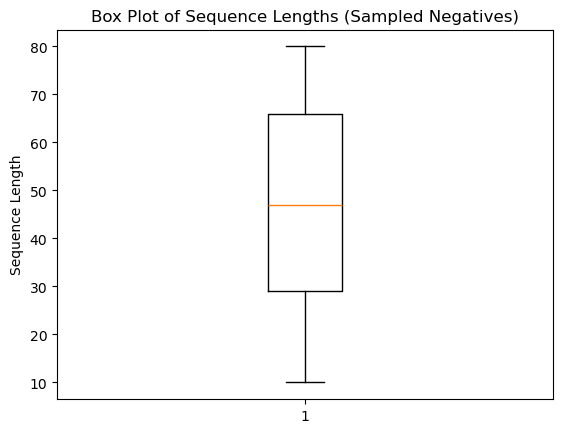

                                              Peptide ID  \
0      sp|C0HJE2|AMYG_BACLI Glucoamylase (Fragment) O...   
1      sp|Q03367|PSBF_CAPAN Cytochrome b559 subunit b...   
2      sp|Q10997|SPI_HALRO Serine proteinase inhibito...   
3      sp|P85962|RLA2_PSEMZ Large ribosomal subunit p...   
4      sp|P02728|GLEM_HUMAN Erythrocyte membrane glyc...   
...                                                  ...   
15418  sp|Q6B8L8|RPOZ_GRATL Putative DNA-directed RNA...   
15419  tr|A0A3N5N678|A0A3N5N678_9HYPH Acyl carrier pr...   
15420  tr|A0A7L0FFZ7|A0A7L0FFZ7_CORCN Serine palmitoy...   
15421  tr|A0A258UY98|A0A258UY98_9SPHN ATP synthase su...   
15422  tr|A0A3C0S7Q9|A0A3C0S7Q9_9BACT DNA-directed RN...   

                                                Sequence  
0                                             SSNKLTTSWG  
1                                             SISAMQFIQR  
2                                             TKKDGEEKVA  
3                                          

In [56]:
# Calculate sequence lengths for uniprot_df
uniprot_df['Sequence Length'] = uniprot_df['Sequence'].apply(len)

# Calculate sequence lengths for adam_df
adam_df['Sequence Length'] = adam_df['Sequences'].apply(len)

# Perform stratified sampling to select more samples
default_min_samples = 30

# Perform lenient stratified sampling
sampled_uniprot_df = uniprot_df.groupby('Sequence Length', group_keys=False).apply(
    lambda x: x.sample(
        n=min(
            len(x), 
            int(14 * adam_df['Sequence Length'].value_counts().get(x.name, default_min_samples))
        ),
        random_state=42
    )
).reset_index(drop=True)
# Drop the 'Sequence Length' column after sampling
sampled_uniprot_df = sampled_uniprot_df.drop(columns=['Sequence Length'])
adam_df = adam_df.drop(columns=['Sequence Length'])

# Draw a box plot to visualize the distribution
plt.boxplot(sampled_uniprot_df['Sequence'].apply(len))
plt.title("Box Plot of Sequence Lengths (Sampled Negatives)")
plt.ylabel("Sequence Length")
plt.show()

print(sampled_uniprot_df)

### data organization

In [62]:

adam_df['label'] = 1
sampled_uniprot_df['label'] = 0
adam_df.columns = ["Peptide ID", "Sequences", 'label']
sampled_uniprot_df.columns = ["Peptide ID", "Sequences" , 'label']
df = pd.concat([adam_df, sampled_uniprot_df], ignore_index=True)

max_length = df['Sequences'].str.len().max()
print(max_length)
# df['Sequences'] = df['Sequences'].apply(lambda x: x.ljust(max_length, 'X'))

unique_letters = set(''.join(df["Sequences"]))
print(unique_letters)
print(len(unique_letters))
amino_acids = set("ACDEFGHIKLMNPQRSTVWYX")
non_standard_amino_acids = unique_letters - amino_acids
print(non_standard_amino_acids)
b_count = df["Sequences"].str.count('B').sum()
print(f"Number of 'B' values: {b_count}")

# Filter out sequences containing non-standard amino acids
df = df[~df['Sequences'].str.contains('|'.join(non_standard_amino_acids))]
df = df.drop_duplicates(subset='Sequences')
tb_df = pd.read_csv('../data/all_seq702.csv')
df = df[~df['Sequences'].isin(tb_df['Sequences'])]
df = df[df['Sequences'].apply(lambda x: isinstance(x, str) and len(x) >= 10)]
print(f"Number of sequences after filtering: {len(df)}")
print(df['label'].value_counts())
X = df["Sequences"]
y = df["label"]

# Split into train (70%), validation (15%), test (15%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Step 2: Split train+val into train and val (stratified)
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)  # 0.1765 to maintain 15% of original dataset




190
{'n', 'k', 'U', 'm', 'V', 'w', 'D', 'M', 'T', 'K', 'f', 'd', 'a', 'r', 'L', 'A', 't', 'q', 'Y', ' ', 'h', 'y', 'W', 'G', 'E', 'C', '9', 's', 'I', 'Z', 'N', 'Q', 'e', 'F', 'p', 'x', 'v', 'X', 'O', 'P', 'i', 'H', 'l', 'g', 'B', 'c', 'S', 'R'}
48
{'n', 'k', 'U', 'm', 'w', 'f', 'd', 'a', 'r', 'q', ' ', 'h', 'y', '9', 's', 'Z', 'e', 'p', 'x', 'v', 'O', 'i', 'l', 'g', 'B', 'c', 't'}
Number of 'B' values: 11
Number of sequences after filtering: 31029
label
1    15839
0    15190
Name: count, dtype: int64


In [71]:
# lengths = [len(seq) for seq in df['Sequences']]
# print(lengths[lengths <= 0])

lengths = np.array([len(seq) for seq in df['Sequences']])
print(lengths[lengths <= 0])


[]


### dataset

In [72]:

# Define One-Hot Encoding Function for DNA Sequences in PyTorch
def one_hot_torch(seq: str, dtype=torch.float32):
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    seq_bytes = torch.ByteTensor(list(bytes(seq, "utf-8")))
    aa_bytes = torch.ByteTensor(list(bytes(amino_acids, "utf-8")))
    arr = torch.zeros(len(amino_acids), len(seq_bytes), dtype=dtype)
    for i, aa in enumerate(aa_bytes):
        arr[i, seq_bytes == aa] = 1
    return arr


class SequenceDataset(Dataset):
    def __init__(self, sequences, labels, one_hot_dtype=torch.float32):
        self.sequences = sequences
        self.labels = labels
        self.one_hot_dtype = one_hot_dtype

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences.iloc[idx]
        label = self.labels.iloc[idx]
        length = len(seq.replace("X", ""))  # unpadded length
        return one_hot_torch(seq, dtype=self.one_hot_dtype), torch.tensor(label, dtype=torch.float32), length

from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

def collate_and_pack(batch):
    # batch = list of (tensor_seq, label, length)
    sequences, labels, lengths = zip(*batch)

    # Filter out sequences with zero length
    filtered_batch = [(seq, lbl, l) for seq, lbl, l in zip(sequences, labels, lengths) if l > 0]

    if len(filtered_batch) == 0:
        raise ValueError("All sequences in the batch have zero length.")

    sequences, labels, lengths = zip(*filtered_batch)

    # Convert lengths to tensor
    lengths = torch.tensor(lengths)

    # Sort by descending length (required by pack_padded_sequence)
    sorted_indices = torch.argsort(lengths, descending=True)
    sequences = [sequences[i] for i in sorted_indices]
    labels = torch.tensor([labels[i] for i in sorted_indices])
    lengths = lengths[sorted_indices]

    # Stack to shape: (batch_size, 20, seq_len) and transpose for LSTM input
    # LSTM expects input of shape (seq_len, batch_size, features)
    sequences = [seq.T for seq in sequences]  # Transpose each [20, L] to [L, 20]
    padded_seqs = pad_sequence(sequences, batch_first=False)  # shape: [max_len, batch, features]

    # Pack the sequence
    packed_input = pack_padded_sequence(padded_seqs, lengths.cpu(), batch_first=False)

    return packed_input, labels



In [73]:
# Define DataLoaders

train_dataset = SequenceDataset(X_train, y_train)
val_dataset = SequenceDataset(X_val, y_val)
test_dataset = SequenceDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_and_pack)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_and_pack)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_and_pack)

    
# Display dataset sizes
dataset_sizes = {
    "Train": len(train_dataset),
    "Validation": len(val_dataset),
    "Test": len(test_dataset)
}
print("Dataset sizes:")
for name, size in dataset_sizes.items():
    print(f"{name}: {size}")

Dataset sizes:
Train: 21720
Validation: 4655
Test: 4654


## testing

In [74]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=False,
            dropout=dropout if num_layers > 1 else 0
        )

        # Classifier
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        # packed_input: PackedSequence
        packed_output, (hn, cn) = self.lstm(packed_input)

        # hn: [num_layers, batch_size, hidden_dim]
        # We'll use the **last layer's** hidden state as feature
        last_hidden = hn[-1]  # shape: [batch_size, hidden_dim]

        # Fully connected + sigmoid
        out = self.fc(last_hidden)       # shape: [batch_size, 1]
        out = self.sigmoid(out).squeeze(1)  # shape: [batch_size]
        return out


In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score

from torch.utils.tensorboard import SummaryWriter
import datetime

def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = 1000.0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_auc': []}

    # Set up TensorBoard writer
    log_dir = f"runs/AMP_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)

        # Run evaluation
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device)

        # Logging
        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        print(f"Epoch [{epoch}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")

        # Save to history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_auc'].append(val_auc)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # torch.save(model.state_dict(), 'best_model.pt')

    writer.close()
    return history

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, recall_score

def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)

    # Convert predicted probabilities to binary predictions
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]

    # Metrics
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    # Confusion matrix
    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)  # handle corner cases

    # Sensitivity and specificity
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        # Print metrics
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity (Recall for Positive Class): {sensitivity:.4f}")
        print(f"Specificity (Recall for Negative Class): {specificity:.4f}")

    return avg_loss, acc, auc


model = LSTMClassifier(hidden_dim=64)
history = train_model(model, train_loader, val_loader, num_epochs=10)


Epoch [1/10] - Train Loss: 0.5227, Val Loss: 0.3842, Val Acc: 0.8451, Val AUC: 0.9235
Epoch [2/10] - Train Loss: 0.3084, Val Loss: 0.2863, Val Acc: 0.8876, Val AUC: 0.9638
Epoch [3/10] - Train Loss: 0.2366, Val Loss: 0.2234, Val Acc: 0.9149, Val AUC: 0.9711
Epoch [4/10] - Train Loss: 0.2087, Val Loss: 0.2155, Val Acc: 0.9218, Val AUC: 0.9741


KeyboardInterrupt: 

### adding in regularization

In [ ]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=False,
            dropout=dropout if num_layers > 1 else 0  # LSTM dropout applies only between layers
        )

        # Dropout after LSTM (even if 1 layer)
        self.dropout = nn.Dropout(dropout)

        # Fully connected classifier
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        packed_output, (hn, cn) = self.lstm(packed_input)

        # Get the last hidden state from the last layer
        last_hidden = hn[-1]  # shape: [batch_size, hidden_dim]

        # Apply dropout
        dropped = self.dropout(last_hidden)

        # Fully connected + sigmoid
        out = self.fc(dropped)       # shape: [batch_size, 1]
        out = self.sigmoid(out).squeeze(1)  # shape: [batch_size]
        return out


def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # L2 regularization

    best_val_loss = 1000.0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_auc': []}

    # Set up TensorBoard writer
    log_dir = f"runs/AMP_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)   
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)

        # Run evaluation
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        # Logging
        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        print(f"Epoch [{epoch}/{num_epochs}] - "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Acc: {val_acc:.4f}, "
              f"Val AUC: {val_auc:.4f}")

        # Save to history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_auc'].append(val_auc)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')

    writer.close()
    return history



from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, recall_score

def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)

    # Convert predicted probabilities to binary predictions
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]

    # Metrics
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    # Confusion matrix
    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)  # handle corner cases

    # Sensitivity and specificity
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        # Print metrics
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity (Recall for Positive Class): {sensitivity:.4f}")
        print(f"Specificity (Recall for Negative Class): {specificity:.4f}")

    return avg_loss, acc, auc

model = LSTMClassifier(input_dim=20, hidden_dim=64, dropout=0.5)
history = train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3,
                      weight_decay=1e-4, verbose=True)



Confusion Matrix:
[[401 160]
 [ 89 407]]
Sensitivity (Recall for Positive Class): 0.8206
Specificity (Recall for Negative Class): 0.7148
Epoch [1/10] - Train Loss: 0.6630, Val Loss: 0.5471, Val Acc: 0.7644, Val AUC: 0.8299

Confusion Matrix:
[[460 101]
 [101 395]]
Sensitivity (Recall for Positive Class): 0.7964
Specificity (Recall for Negative Class): 0.8200
Epoch [2/10] - Train Loss: 0.5161, Val Loss: 0.4849, Val Acc: 0.8089, Val AUC: 0.8625

Confusion Matrix:
[[192 369]
 [ 29 467]]
Sensitivity (Recall for Positive Class): 0.9415
Specificity (Recall for Negative Class): 0.3422
Epoch [3/10] - Train Loss: 0.6564, Val Loss: 0.6466, Val Acc: 0.6235, Val AUC: 0.8047

Confusion Matrix:
[[424 137]
 [119 377]]
Sensitivity (Recall for Positive Class): 0.7601
Specificity (Recall for Negative Class): 0.7558
Epoch [4/10] - Train Loss: 0.5960, Val Loss: 0.5372, Val Acc: 0.7578, Val AUC: 0.8364

Confusion Matrix:
[[458 103]
 [ 77 419]]
Sensitivity (Recall for Positive Class): 0.8448
Specificity (R

## Modelling on general AMP data (bayesian optimization)

### LSTM

In [76]:

import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
import datetime


class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=False,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        packed_output, (hn, cn) = self.lstm(packed_input)
        last_hidden = hn[-1]
        dropped = self.dropout(last_hidden)
        out = self.fc(dropped)
        out = self.sigmoid(out).squeeze(1)
        return out


def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False, train=False):
    model.to(device)
    # if not train:
    #     model.eval()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000

    log_dir = f"runs-lstm/AMP_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if train:
                torch.save(model.state_dict(), 'best_model_lstm_.pt')

    writer.close()
    return best_val_loss



def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

    return avg_loss, acc, auc


def objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 32, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2)

    model = LSTMClassifier(input_dim=20, hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout)
    val_auc = train_model(model, train_loader, val_loader, num_epochs=20, lr=lr,
                          weight_decay=weight_decay, verbose=False, train=True)
    return val_auc


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best hyperparameters:", study.best_trial.params)
lstm_best_param = study.best_trial.params

[I 2025-04-23 22:29:56,492] A new study created in memory with name: no-name-578f1e60-413e-4f31-aa4b-6525a19e5672
[I 2025-04-23 22:39:19,317] Trial 0 finished with value: 0.20186862716936085 and parameters: {'hidden_dim': 118, 'num_layers': 2, 'dropout': 0.15770098555716838, 'lr': 0.0033631098397860566, 'weight_decay': 0.0016651826858557562}. Best is trial 0 with value: 0.20186862716936085.
[I 2025-04-23 22:47:05,995] Trial 1 finished with value: 0.20391635106850978 and parameters: {'hidden_dim': 86, 'num_layers': 1, 'dropout': 0.3730028207259446, 'lr': 0.006315513405964547, 'weight_decay': 0.004771900430672791}. Best is trial 0 with value: 0.20186862716936085.
[I 2025-04-23 22:55:50,323] Trial 2 finished with value: 0.6929459988254391 and parameters: {'hidden_dim': 91, 'num_layers': 2, 'dropout': 0.18846678538578907, 'lr': 0.009849482264248585, 'weight_decay': 0.006762646719950194}. Best is trial 0 with value: 0.20186862716936085.
[I 2025-04-23 23:03:10,159] Trial 3 finished with valu

Best hyperparameters: {'hidden_dim': 32, 'num_layers': 1, 'dropout': 0.4902444099362521, 'lr': 0.0043057438074332, 'weight_decay': 0.00013769582938473473}


#### testing

In [77]:
# model = LSTMClassifier(input_dim=20, hidden_dim=47, num_layers=2, dropout=0.18950252633567022)
# history = train_model(model, train_loader, val_loader, num_epochs=19, lr=0.009528266081905703,
#                       weight_decay=1.1052415577383506e-05, verbose=True)

model = LSTMClassifier(input_dim=20, hidden_dim=lstm_best_param['hidden_dim'], num_layers=lstm_best_param['num_layers'], dropout= lstm_best_param['dropout'])
history = train_model(model, train_loader, val_loader, num_epochs=20, lr=lstm_best_param['lr'],
                      weight_decay=lstm_best_param['weight_decay'], verbose=True, train=False)
criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")

torch.save(model.state_dict(), 'best_model_lstm_1.pt')


Confusion Matrix:
[[1852  427]
 [  99 2277]]
Sensitivity: 0.9583, Specificity: 0.8126
Epoch [1/20] - Train Loss: 0.5112, Val Loss: 0.3194, Val Acc: 0.8870, Val AUC: 0.9587

Confusion Matrix:
[[2006  273]
 [ 104 2272]]
Sensitivity: 0.9562, Specificity: 0.8802
Epoch [2/20] - Train Loss: 0.2733, Val Loss: 0.2144, Val Acc: 0.9190, Val AUC: 0.9715

Confusion Matrix:
[[2095  184]
 [ 175 2201]]
Sensitivity: 0.9263, Specificity: 0.9193
Epoch [3/20] - Train Loss: 0.2374, Val Loss: 0.2003, Val Acc: 0.9229, Val AUC: 0.9755

Confusion Matrix:
[[2001  278]
 [  91 2285]]
Sensitivity: 0.9617, Specificity: 0.8780
Epoch [4/20] - Train Loss: 0.2140, Val Loss: 0.1964, Val Acc: 0.9207, Val AUC: 0.9766

Confusion Matrix:
[[2123  156]
 [ 190 2186]]
Sensitivity: 0.9200, Specificity: 0.9315
Epoch [5/20] - Train Loss: 0.1940, Val Loss: 0.1948, Val Acc: 0.9257, Val AUC: 0.9779

Confusion Matrix:
[[2097  182]
 [ 143 2233]]
Sensitivity: 0.9398, Specificity: 0.9201
Epoch [6/20] - Train Loss: 0.1859, Val Loss: 0.1

### biLSTM

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
import datetime

# Updated BiLSTM with flatten layer as previously defined
class BiLSTMWithFlattenClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3, max_seq_len=100):
        super(BiLSTMWithFlattenClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.max_seq_len = max_seq_len

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(max_seq_len * hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        unpacked, lengths = pad_packed_sequence(packed_input, batch_first=True)
        lstm_out, _ = self.lstm(unpacked)

        batch_size, seq_len, feature_dim = lstm_out.size()

        if seq_len < self.max_seq_len:
            pad_len = self.max_seq_len - seq_len
            pad = torch.zeros(batch_size, pad_len, feature_dim, device=lstm_out.device)
            lstm_out = torch.cat([lstm_out, pad], dim=1)
        elif seq_len > self.max_seq_len:
            lstm_out = lstm_out[:, :self.max_seq_len, :]

        dropped = self.dropout(lstm_out)
        flat = dropped.contiguous().view(batch_size, -1)
        out = self.fc(flat)
        return self.sigmoid(out).squeeze(1)

# Evaluation function
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

    return avg_loss, acc, auc

# Training function
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000.0

    log_dir = f"runs-bilstm_flatten/BiLSTM_Flatten_Optuna_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model-bilstm.pt')

    writer.close()
    return best_val_loss

# Optuna objective function
def objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 32, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2)
    max_seq_len = 100  # fixed for now; match your padding/truncation

    model = BiLSTMWithFlattenClassifier(
        input_dim=20,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout=dropout,
        max_seq_len=max_seq_len
    )

    val_auc = train_model(
        model,
        train_loader,
        val_loader,
        num_epochs=10,
        lr=lr,
        weight_decay=weight_decay,
        verbose=False
    )
    return val_auc

# Usage (uncomment and run in your local environment):
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_trial.params)
bilstm_best_param = study.best_trial.params

[I 2025-04-24 00:59:49,644] A new study created in memory with name: no-name-db27d220-723a-4c38-b7b1-3cd6955bfa35
[I 2025-04-24 01:03:13,275] Trial 0 finished with value: 0.19840536062439826 and parameters: {'hidden_dim': 100, 'num_layers': 2, 'dropout': 0.21295967703838065, 'lr': 0.00575844680005971, 'weight_decay': 0.004380793434831622}. Best is trial 0 with value: 0.19840536062439826.
[I 2025-04-24 01:06:43,201] Trial 1 finished with value: 0.1979307351659422 and parameters: {'hidden_dim': 66, 'num_layers': 3, 'dropout': 0.17505347426176818, 'lr': 0.006200857156169697, 'weight_decay': 0.004379496497472087}. Best is trial 1 with value: 0.1979307351659422.
[I 2025-04-24 01:10:04,464] Trial 2 finished with value: 0.22604743340244032 and parameters: {'hidden_dim': 97, 'num_layers': 3, 'dropout': 0.43234003386883213, 'lr': 0.0055050768054949175, 'weight_decay': 0.007911101000066968}. Best is trial 1 with value: 0.1979307351659422.
[I 2025-04-24 01:13:42,665] Trial 3 finished with value: 

Best hyperparameters: {'hidden_dim': 127, 'num_layers': 1, 'dropout': 0.2794048413737868, 'lr': 0.0030378137748946626, 'weight_decay': 0.00010269830007820016}


In [79]:
bilstm_best_param

{'hidden_dim': 127,
 'num_layers': 1,
 'dropout': 0.2794048413737868,
 'lr': 0.0030378137748946626,
 'weight_decay': 0.00010269830007820016}

In [80]:
# model = LSTMClassifier(input_dim=20, hidden_dim=47, num_layers=2, dropout=0.18950252633567022)
# history = train_model(model, train_loader, val_loader, num_epochs=19, lr=0.009528266081905703,
#                       weight_decay=1.1052415577383506e-05, verbose=True)

model = LSTMClassifier(input_dim=20, hidden_dim=bilstm_best_param['hidden_dim'], num_layers=bilstm_best_param['num_layers'], dropout= bilstm_best_param['dropout'])
history = train_model(model, train_loader, val_loader, num_epochs=30, lr=bilstm_best_param['lr'],
                      weight_decay=bilstm_best_param['weight_decay'], verbose=True)
criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")


Confusion Matrix:
[[1955  324]
 [ 148 2228]]
Sensitivity: 0.9377, Specificity: 0.8578
Epoch [1/30] - Train Loss: 0.4831, Val Loss: 0.3297, Val Acc: 0.8986, Val AUC: 0.9449

Confusion Matrix:
[[2030  249]
 [ 134 2242]]
Sensitivity: 0.9436, Specificity: 0.8907
Epoch [2/30] - Train Loss: 0.2328, Val Loss: 0.2184, Val Acc: 0.9177, Val AUC: 0.9732

Confusion Matrix:
[[2055  224]
 [ 145 2231]]
Sensitivity: 0.9390, Specificity: 0.9017
Epoch [3/30] - Train Loss: 0.2088, Val Loss: 0.2019, Val Acc: 0.9207, Val AUC: 0.9755

Confusion Matrix:
[[2086  193]
 [ 166 2210]]
Sensitivity: 0.9301, Specificity: 0.9153
Epoch [4/30] - Train Loss: 0.2030, Val Loss: 0.1905, Val Acc: 0.9229, Val AUC: 0.9777

Confusion Matrix:
[[2106  173]
 [ 159 2217]]
Sensitivity: 0.9331, Specificity: 0.9241
Epoch [5/30] - Train Loss: 0.1824, Val Loss: 0.1785, Val Acc: 0.9287, Val AUC: 0.9811

Confusion Matrix:
[[2086  193]
 [ 118 2258]]
Sensitivity: 0.9503, Specificity: 0.9153
Epoch [6/30] - Train Loss: 0.1686, Val Loss: 0.1

### lstm + attention

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
import datetime

# LSTM with Attention classifier
class LSTMWithAttentionClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3):
        super(LSTMWithAttentionClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )

        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        unpacked, lengths = pad_packed_sequence(packed_input, batch_first=True)
        lstm_out, _ = self.lstm(unpacked)  # shape: [batch, seq_len, hidden_dim]

        # Compute attention weights
        attn_weights = self.attn(lstm_out).squeeze(-1)  # shape: [batch, seq_len]
        attn_weights = torch.softmax(attn_weights, dim=1)  # normalize
        attn_applied = torch.sum(lstm_out * attn_weights.unsqueeze(-1), dim=1)  # shape: [batch, hidden_dim]

        dropped = self.dropout(attn_applied)
        out = self.fc(dropped)
        return self.sigmoid(out).squeeze(1)

# Evaluation function
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

    return avg_loss, acc, auc

# Training function
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000

    log_dir = f"runs-lstm-attn/LSTM_Attn_Optuna_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model-lstm_attention.pt')

    writer.close()
    return best_val_loss

# Optuna objective function
def objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 32, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)

    model = LSTMWithAttentionClassifier(
        input_dim=20,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout=dropout
    )

    val_auc = train_model(
        model,
        train_loader,
        val_loader,
        num_epochs=10,
        lr=lr,
        weight_decay=weight_decay,
        verbose=False
    )
    return val_auc

# Usage
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_trial.params)
lstm_attn_best_param = study.best_trial.params

[I 2025-04-24 02:14:04,336] A new study created in memory with name: no-name-584e9dbd-ffd9-44dd-afec-856078a359b1


[I 2025-04-24 02:16:43,388] Trial 0 finished with value: 0.18178581778113156 and parameters: {'hidden_dim': 43, 'num_layers': 3, 'dropout': 0.16688084395799957, 'lr': 0.0016967913084958185, 'weight_decay': 2.1368172284833312e-06}. Best is trial 0 with value: 0.18178581778113156.
[I 2025-04-24 02:19:22,199] Trial 1 finished with value: 0.2197459757532159 and parameters: {'hidden_dim': 52, 'num_layers': 2, 'dropout': 0.30214792017447845, 'lr': 0.0010077852489961392, 'weight_decay': 0.00045081063760837794}. Best is trial 0 with value: 0.18178581778113156.
[I 2025-04-24 02:22:04,103] Trial 2 finished with value: 0.17075231564167428 and parameters: {'hidden_dim': 111, 'num_layers': 2, 'dropout': 0.29727846759967036, 'lr': 0.0015935281764741956, 'weight_decay': 1.4521347161197535e-05}. Best is trial 2 with value: 0.17075231564167428.
[I 2025-04-24 02:24:37,915] Trial 3 finished with value: 0.1632602711348501 and parameters: {'hidden_dim': 119, 'num_layers': 2, 'dropout': 0.4296783485284802, 

Best hyperparameters: {'hidden_dim': 73, 'num_layers': 1, 'dropout': 0.42257973470705656, 'lr': 0.007949617623932719, 'weight_decay': 7.416073340484421e-06}


In [82]:
# model = LSTMClassifier(input_dim=20, hidden_dim=47, num_layers=2, dropout=0.18950252633567022)
# history = train_model(model, train_loader, val_loader, num_epochs=19, lr=0.009528266081905703,
#                       weight_decay=1.1052415577383506e-05, verbose=True)

model = LSTMClassifier(input_dim=20, hidden_dim=lstm_attn_best_param['hidden_dim'], num_layers=lstm_attn_best_param['num_layers'], dropout= lstm_attn_best_param['dropout'])
history = train_model(model, train_loader, val_loader, num_epochs=20, lr=lstm_attn_best_param['lr'],
                      weight_decay=lstm_attn_best_param['weight_decay'], verbose=True)
criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")


Confusion Matrix:
[[1768  511]
 [ 250 2126]]
Sensitivity: 0.8948, Specificity: 0.7758
Epoch [1/20] - Train Loss: 0.5481, Val Loss: 0.4131, Val Acc: 0.8365, Val AUC: 0.9009

Confusion Matrix:
[[1300  979]
 [ 133 2243]]
Sensitivity: 0.9440, Specificity: 0.5704
Epoch [2/20] - Train Loss: 0.4977, Val Loss: 0.5078, Val Acc: 0.7611, Val AUC: 0.8885

Confusion Matrix:
[[1968  311]
 [  88 2288]]
Sensitivity: 0.9630, Specificity: 0.8635
Epoch [3/20] - Train Loss: 0.2632, Val Loss: 0.2269, Val Acc: 0.9143, Val AUC: 0.9743

Confusion Matrix:
[[2078  201]
 [ 144 2232]]
Sensitivity: 0.9394, Specificity: 0.9118
Epoch [4/20] - Train Loss: 0.2052, Val Loss: 0.1968, Val Acc: 0.9259, Val AUC: 0.9770

Confusion Matrix:
[[1987  292]
 [  90 2286]]
Sensitivity: 0.9621, Specificity: 0.8719
Epoch [5/20] - Train Loss: 0.1880, Val Loss: 0.1873, Val Acc: 0.9179, Val AUC: 0.9800

Confusion Matrix:
[[2131  148]
 [ 149 2227]]
Sensitivity: 0.9373, Specificity: 0.9351
Epoch [6/20] - Train Loss: 0.1726, Val Loss: 0.1

### bilstm + attn

In [83]:

import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
import datetime

# BiLSTM with Attention Classifier
class BiLSTMWithAttentionClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3):
        super(BiLSTMWithAttentionClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        unpacked, lengths = pad_packed_sequence(packed_input, batch_first=True)
        lstm_out, _ = self.lstm(unpacked)

        # Attention mechanism
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)

        dropped = self.dropout(context_vector)
        out = self.fc(dropped)
        return self.sigmoid(out).squeeze(1)

# Evaluation function
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

    return avg_loss, acc, auc

# Training function
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000.0

    log_dir = f"runs-bilstm_attention/BiLSTM_Attention_Optuna_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model-bilstm_attention.pt')

    writer.close()
    return best_val_loss

# Optuna objective function
def objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 32, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2)

    model = BiLSTMWithAttentionClassifier(
        input_dim=20,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout=dropout
    )

    val_auc = train_model(
        model,
        train_loader,
        val_loader,
        num_epochs=10,
        lr=lr,
        weight_decay=weight_decay,
        verbose=False
    )
    return val_auc

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_trial.params)
bilstm_attn_best_param = study.best_trial.params


[I 2025-04-24 03:19:50,499] A new study created in memory with name: no-name-4b004da4-2ef1-49f0-9209-827009ce76f7


[I 2025-04-24 03:22:51,419] Trial 0 finished with value: 0.19018186618612237 and parameters: {'hidden_dim': 43, 'num_layers': 1, 'dropout': 0.13900372495935556, 'lr': 0.005216606119325261, 'weight_decay': 0.0027449152028254267}. Best is trial 0 with value: 0.19018186618612237.
[I 2025-04-24 03:25:55,543] Trial 1 finished with value: 0.6929475861052944 and parameters: {'hidden_dim': 107, 'num_layers': 2, 'dropout': 0.29980588033125843, 'lr': 0.005322469898777397, 'weight_decay': 0.003111427563486947}. Best is trial 0 with value: 0.19018186618612237.
[I 2025-04-24 03:28:42,499] Trial 2 finished with value: 0.22952822299852763 and parameters: {'hidden_dim': 40, 'num_layers': 1, 'dropout': 0.30692636212754404, 'lr': 0.0031868149143787885, 'weight_decay': 0.007963465800881734}. Best is trial 0 with value: 0.19018186618612237.
[I 2025-04-24 03:31:32,531] Trial 3 finished with value: 0.21738621092414204 and parameters: {'hidden_dim': 75, 'num_layers': 1, 'dropout': 0.19629973431601655, 'lr': 

Best hyperparameters: {'hidden_dim': 72, 'num_layers': 3, 'dropout': 0.4154040883157904, 'lr': 0.0011999905002511623, 'weight_decay': 1.9408679083588733e-05}


In [84]:


# Training function
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000.0

    log_dir = f"runs-bilstm_attention/BiLSTM_Attention_Optuna_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # torch.save(model.state_dict(), 'best_model-bilstm_attention.pt')


model = BiLSTMWithAttentionClassifier(
    input_dim=20,
    hidden_dim=bilstm_attn_best_param['hidden_dim'],
    num_layers=bilstm_attn_best_param['num_layers'],
    dropout=bilstm_attn_best_param['dropout']
)
history = train_model(model, train_loader, val_loader, num_epochs=30, lr=bilstm_attn_best_param['lr'],
                      weight_decay=bilstm_attn_best_param['weight_decay'], verbose=True)

criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")



Confusion Matrix:
[[1988  291]
 [ 108 2268]]
Sensitivity: 0.9545, Specificity: 0.8723
Epoch [1/30] - Train Loss: 0.3178, Val Loss: 0.2226, Val Acc: 0.9143, Val AUC: 0.9711

Confusion Matrix:
[[2121  158]
 [ 201 2175]]
Sensitivity: 0.9154, Specificity: 0.9307
Epoch [2/30] - Train Loss: 0.2155, Val Loss: 0.1942, Val Acc: 0.9229, Val AUC: 0.9775

Confusion Matrix:
[[1960  319]
 [ 103 2273]]
Sensitivity: 0.9566, Specificity: 0.8600
Epoch [3/30] - Train Loss: 0.1894, Val Loss: 0.2038, Val Acc: 0.9093, Val AUC: 0.9762

Confusion Matrix:
[[2025  254]
 [  89 2287]]
Sensitivity: 0.9625, Specificity: 0.8885
Epoch [4/30] - Train Loss: 0.1801, Val Loss: 0.1754, Val Acc: 0.9263, Val AUC: 0.9813

Confusion Matrix:
[[2105  174]
 [ 148 2228]]
Sensitivity: 0.9377, Specificity: 0.9237
Epoch [5/30] - Train Loss: 0.1679, Val Loss: 0.1704, Val Acc: 0.9308, Val AUC: 0.9818

Confusion Matrix:
[[2025  254]
 [  97 2279]]
Sensitivity: 0.9592, Specificity: 0.8885
Epoch [6/30] - Train Loss: 0.1630, Val Loss: 0.1

## Transfer learning to TB data

### data

In [5]:
df = pd.read_csv('../data/all_seq702.csv')
df = df.drop_duplicates(subset='Sequences')
max_length = df['Sequences'].str.len().max()
print(max_length)
# df['Sequences'] = df['Sequences'].apply(lambda x: x.ljust(max_length, 'X'))

unique_letters = set(''.join(df["Sequences"]))
print(unique_letters)
print(len(unique_letters))
amino_acids = set("ACDEFGHIKLMNPQRSTVWY")
non_standard_amino_acids = unique_letters - amino_acids
print(non_standard_amino_acids)
b_count = df["Sequences"].str.count('B').sum()
print(f"Number of 'B' values: {b_count}")
# manually replaced one of the B with D and the other with N

df = df[
    (df['Sequences'].str.len() >= 10) &
    (df['Sequences'].apply(lambda x: len(set(x)) > 1)) &
    (~df['Sequences'].str.contains('X'))
]

X = df["Sequences"]
y = df["AMP"]


# Split into train (70%), validation (15%), test (15%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Step 2: Split train+val into train and val (stratified)
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)  # 0.1765 to maintain 15% of original dataset



128
{'W', 'P', 'K', 'X', 'H', 'F', 'A', 'V', 'G', 'T', 'N', 'I', 'M', 'S', 'Q', 'R', 'Y', 'C', 'D', 'L', 'E'}
21
{'X'}
Number of 'B' values: 0


In [6]:
df["AMP"].value_counts()

AMP
0.0    235
1.0    205
Name: count, dtype: int64

In [86]:
# Define DataLoaders

train_dataset = SequenceDataset(X_train, y_train)
val_dataset = SequenceDataset(X_val, y_val)
test_dataset = SequenceDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_and_pack)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_and_pack)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_and_pack)

    
# Display dataset sizes
dataset_sizes = {
    "Train": len(train_dataset),
    "Validation": len(val_dataset),
    "Test": len(test_dataset)
}
print("Dataset sizes:")
for name, size in dataset_sizes.items():
    print(f"{name}: {size}")

Dataset sizes:
Train: 264
Validation: 88
Test: 88


### LSTM

#### frozen encoder

In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
import datetime
from torch.utils.tensorboard import SummaryWriter

# LSTM Classifier (same as before)
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=False,
            dropout=dropout if num_layers > 1 else 0  # LSTM dropout applies only between layers
        )

        # Dropout after LSTM (even if 1 layer)
        self.dropout = nn.Dropout(dropout)

        # Fully connected classifier
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        packed_output, (hn, cn) = self.lstm(packed_input)

        # Get the last hidden state from the last layer
        last_hidden = hn[-1]  # shape: [batch_size, hidden_dim]

        # Apply dropout
        dropped = self.dropout(last_hidden)

        # Fully connected + sigmoid
        out = self.fc(dropped)       # shape: [batch_size, 1]
        out = self.sigmoid(out).squeeze(1)  # shape: [batch_size]
        return out


# Function to freeze the encoder (LSTM)
def freeze_encoder(model):
    for name, param in model.named_parameters():
        if 'lstm' in name:
            param.requires_grad = False

# Evaluation function with detailed output
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=True):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0
    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')

    # print(f"\nFinal Evaluation on Best Model:")
    # print(f"Accuracy: {acc:.4f}, AUC: {auc:.4f}")
    # print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
    # print(f"Confusion Matrix:\n{cm}")

    return avg_loss, acc, auc

# Training function for frozen encoder
def train_finetune_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                         device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

    best_val_loss = 1000
    log_dir = f"runs-lstm-trans-frozen/FrozenEncoder_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=False)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        # if val_auc > best_val_auc:
        #     best_val_auc = val_auc
        #     torch.save(model.state_dict(), 'best_model_frozen.pt')
            
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_lstm_frozen.pt')

    writer.close()
    return best_val_loss


import optuna

def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    model = LSTMClassifier(input_dim=20, hidden_dim=lstm_best_param['hidden_dim'], num_layers=lstm_best_param['num_layers'], dropout=dropout)
    model.load_state_dict(torch.load('best_model_lstm_1.pt'))
    
    freeze_encoder(model)

    return train_finetune_model(
        model, train_loader, val_loader,
        num_epochs=15, lr=lr, weight_decay=weight_decay
    )


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_trial.params)
lstm_frozen_best_param = study.best_trial.params

[I 2025-04-24 04:26:40,908] A new study created in memory with name: no-name-63868d4a-02aa-47f1-bd28-96c49a0a516d


[I 2025-04-24 04:26:44,271] Trial 0 finished with value: 0.29968616366386414 and parameters: {'lr': 0.003965124150798926, 'weight_decay': 4.843807430377461e-05, 'dropout': 0.3212122237525864}. Best is trial 0 with value: 0.29968616366386414.
[I 2025-04-24 04:26:47,398] Trial 1 finished with value: 0.506826917330424 and parameters: {'lr': 5.141802555767809e-05, 'weight_decay': 1.3693120935274958e-06, 'dropout': 0.4920347687027704}. Best is trial 0 with value: 0.29968616366386414.
[I 2025-04-24 04:26:50,492] Trial 2 finished with value: 0.5105321804682413 and parameters: {'lr': 1.6530847407386235e-05, 'weight_decay': 9.06201046128733e-06, 'dropout': 0.4428268477985905}. Best is trial 0 with value: 0.29968616366386414.
[I 2025-04-24 04:26:53,583] Trial 3 finished with value: 0.4718224306901296 and parameters: {'lr': 0.00039388040983086184, 'weight_decay': 0.0004552538230940001, 'dropout': 0.3635698941400992}. Best is trial 0 with value: 0.29968616366386414.
[I 2025-04-24 04:26:56,658] Tri

Best hyperparameters: {'lr': 0.009830738282818238, 'weight_decay': 0.00010986177815344734, 'dropout': 0.23636753992110987}


In [88]:
lstm_frozen_best_param

{'lr': 0.009830738282818238,
 'weight_decay': 0.00010986177815344734,
 'dropout': 0.23636753992110987}

In [89]:
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=True):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')

    print(f"\nFinal Evaluation on Best Model:")
    print(f"Accuracy: {acc:.4f}, AUC: {auc:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    return avg_loss, acc, auc

def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000

    log_dir = f"runs-lstm-trans-frozen/AMP_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # torch.save(model.state_dict(), 'best_model_lstm.pt')

    writer.close()
    return best_val_loss

# Best hyperparameters: {'lr': 0.009940295438316211, 'weight_decay': 1.4383289881186473e-05, 'dropout': 0.22563027249521914}

model = LSTMClassifier(input_dim=20, hidden_dim=lstm_best_param['hidden_dim'], num_layers=lstm_best_param['num_layers'], dropout=lstm_frozen_best_param['dropout'])
model.load_state_dict(torch.load('best_model_lstm_1.pt'))
freeze_encoder(model)

history = train_model(model, train_loader, val_loader, num_epochs=20, lr=lstm_frozen_best_param['lr'],
                      weight_decay=lstm_frozen_best_param['weight_decay'], verbose=True)

criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")


Final Evaluation on Best Model:
Accuracy: 0.8295, AUC: 0.9507
Sensitivity: 1.0000, Specificity: 0.6809
Confusion Matrix:
[[32 15]
 [ 0 41]]
Epoch [1/20] - Train Loss: 0.6295, Val Loss: 0.4410, Val Acc: 0.8295, Val AUC: 0.9507

Final Evaluation on Best Model:
Accuracy: 0.8523, AUC: 0.9502
Sensitivity: 1.0000, Specificity: 0.7234
Confusion Matrix:
[[34 13]
 [ 0 41]]
Epoch [2/20] - Train Loss: 0.5424, Val Loss: 0.3936, Val Acc: 0.8523, Val AUC: 0.9502

Final Evaluation on Best Model:
Accuracy: 0.8523, AUC: 0.9502
Sensitivity: 0.9756, Specificity: 0.7447
Confusion Matrix:
[[35 12]
 [ 1 40]]
Epoch [3/20] - Train Loss: 0.4616, Val Loss: 0.3542, Val Acc: 0.8523, Val AUC: 0.9502

Final Evaluation on Best Model:
Accuracy: 0.8523, AUC: 0.9512
Sensitivity: 0.9512, Specificity: 0.7660
Confusion Matrix:
[[36 11]
 [ 2 39]]
Epoch [4/20] - Train Loss: 0.4877, Val Loss: 0.3255, Val Acc: 0.8523, Val AUC: 0.9512

Final Evaluation on Best Model:
Accuracy: 0.8636, AUC: 0.9517
Sensitivity: 0.9512, Specific

#### full backprop

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
import datetime
from torch.utils.tensorboard import SummaryWriter

# LSTM Classifier (same as before)
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=False,
            dropout=dropout if num_layers > 1 else 0  # LSTM dropout applies only between layers
        )

        # Dropout after LSTM (even if 1 layer)
        self.dropout = nn.Dropout(dropout)

        # Fully connected classifier
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        packed_output, (hn, cn) = self.lstm(packed_input)

        # Get the last hidden state from the last layer
        last_hidden = hn[-1]  # shape: [batch_size, hidden_dim]

        # Apply dropout
        dropped = self.dropout(last_hidden)

        # Fully connected + sigmoid
        out = self.fc(dropped)       # shape: [batch_size, 1]
        out = self.sigmoid(out).squeeze(1)  # shape: [batch_size]
        return out


# Function to freeze the encoder (LSTM)
def freeze_encoder(model):
    for name, param in model.named_parameters():
        if 'lstm' in name:
            param.requires_grad = False

# Evaluation function with detailed output
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=True):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')

    # print(f"\nFinal Evaluation on Best Model:")
    # print(f"Accuracy: {acc:.4f}, AUC: {auc:.4f}")
    # print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
    # print(f"Confusion Matrix:\n{cm}")

    return avg_loss, acc, auc

# Training function for frozen encoder
def train_finetune_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                         device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

    best_val_loss = 1000.0
    log_dir = f"runs-lstm-transfer-fullbackprop/fullbackprop_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=False)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        # if val_auc > best_val_auc:
        #     best_val_auc = val_auc
        #     torch.save(model.state_dict(), 'best_model_frozen.pt')
            
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_lstm_full_backprop.pt')

    writer.close()
    return best_val_loss

# # Load the best pretrained model and fine-tune
# def finetune_with_frozen_encoder(pretrained_model_path, train_loader, val_loader, hidden_dim, num_layers, dropout):
#     model = LSTMClassifier(input_dim=20, hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout)
#     model.load_state_dict(torch.load(pretrained_model_path))
#     # freeze_encoder(model)

#     best_auc = train_finetune_model(
#         model=model,
#         train_loader=train_loader,
#         val_loader=val_loader,
#         num_epochs=10,
#         lr=1e-3,
#         weight_decay=1e-4
#     )

#     model.load_state_dict(torch.load('best_model_frozen.pt'))
#     evaluate_model(model, val_loader, nn.BCELoss())

#     return model, best_auc

# model, best_auc = finetune_with_frozen_encoder(
#     pretrained_model_path='best_model-lstm.pt',
#     train_loader=train_loader,
#     val_loader=val_loader,
#     hidden_dim=47,  # or from Optuna
#     num_layers=2,
#     dropout=0.3
# )


# lstm_best_param = {'hidden_dim': 74,
#  'num_layers': 3,
#  'dropout': 0.3037059572844035,
#  'lr': 0.00774103421243492,
#  'weight_decay': 2.4221276513292614e-05}

import optuna

def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    model = LSTMClassifier(input_dim=20, hidden_dim=lstm_best_param['hidden_dim'], num_layers=lstm_best_param['num_layers'], dropout=dropout)
    model.load_state_dict(torch.load('best_model_lstm_1.pt'))
    # freeze_encoder(model)

    return train_finetune_model(
        model, train_loader, val_loader,
        num_epochs=15, lr=lr, weight_decay=weight_decay
    )

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_trial.params)
lstm_fullbackprop_best_param = study.best_trial.params


[I 2025-04-24 04:27:46,810] A new study created in memory with name: no-name-13015497-b33e-4d06-87cb-b0864f1b02e4


[I 2025-04-24 04:27:49,895] Trial 0 finished with value: 0.1774317423502604 and parameters: {'lr': 0.001025891617117429, 'weight_decay': 1.1645688809531886e-06, 'dropout': 0.47164158775400755}. Best is trial 0 with value: 0.1774317423502604.
[I 2025-04-24 04:27:53,376] Trial 1 finished with value: 0.17016056180000305 and parameters: {'lr': 0.000647881621177116, 'weight_decay': 0.006301578377335753, 'dropout': 0.45113349794553415}. Best is trial 1 with value: 0.17016056180000305.
[I 2025-04-24 04:27:56,870] Trial 2 finished with value: 0.27499156693617505 and parameters: {'lr': 0.00013338084335559627, 'weight_decay': 0.0002453316452267952, 'dropout': 0.349075357435251}. Best is trial 1 with value: 0.17016056180000305.
[I 2025-04-24 04:28:00,244] Trial 3 finished with value: 0.39594284693400067 and parameters: {'lr': 2.9182380419929234e-05, 'weight_decay': 2.554008805380876e-05, 'dropout': 0.1766061331454447}. Best is trial 1 with value: 0.17016056180000305.
[I 2025-04-24 04:28:03,628] T

Best hyperparameters: {'lr': 0.0024327208300422964, 'weight_decay': 0.005267981516856891, 'dropout': 0.10928487433767066}


In [91]:
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=True):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 1000.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')

    print(f"\nFinal Evaluation on Best Model:")
    print(f"Accuracy: {acc:.4f}, AUC: {auc:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    return avg_loss, acc, auc



def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False, train=False):
    model.to(device)
    if not train:
        model.eval()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000

    log_dir = f"runs-lstm/AMP_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if train:
                torch.save(model.state_dict(), 'best_model_lstm.pt')

    writer.close()
    return best_val_loss

# Best hyperparameters: {'lr': 0.008986542560528932, 'weight_decay': 2.3033044758439348e-06, 'dropout': 0.17164705350229123}

model = LSTMClassifier(input_dim=20, hidden_dim=113, num_layers=1, dropout=lstm_fullbackprop_best_param['dropout'])
history = train_model(model, train_loader, val_loader, num_epochs=19, lr=lstm_fullbackprop_best_param['lr'],
                      weight_decay=lstm_fullbackprop_best_param['weight_decay'], verbose=True, train=False)

criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")



Final Evaluation on Best Model:
Accuracy: 0.5114, AUC: 0.7488
Sensitivity: 1.0000, Specificity: 0.0851
Confusion Matrix:
[[ 4 43]
 [ 0 41]]
Epoch [1/19] - Train Loss: 0.6959, Val Loss: 334.0241, Val Acc: 0.5114, Val AUC: 0.7488

Final Evaluation on Best Model:
Accuracy: 0.5455, AUC: 0.7717
Sensitivity: 0.0244, Specificity: 1.0000
Confusion Matrix:
[[47  0]
 [40  1]]
Epoch [2/19] - Train Loss: 0.6860, Val Loss: 334.0180, Val Acc: 0.5455, Val AUC: 0.7717

Final Evaluation on Best Model:
Accuracy: 0.5341, AUC: 0.7753
Sensitivity: 0.0000, Specificity: 1.0000
Confusion Matrix:
[[47  0]
 [41  0]]
Epoch [3/19] - Train Loss: 0.6809, Val Loss: 334.0131, Val Acc: 0.5341, Val AUC: 0.7753

Final Evaluation on Best Model:
Accuracy: 0.5455, AUC: 0.7852
Sensitivity: 0.0244, Specificity: 1.0000
Confusion Matrix:
[[47  0]
 [40  1]]
Epoch [4/19] - Train Loss: 0.6719, Val Loss: 334.0061, Val Acc: 0.5455, Val AUC: 0.7852

Final Evaluation on Best Model:
Accuracy: 0.5909, AUC: 0.7878
Sensitivity: 0.1951, 

### BiLSTM

#### frozen

In [92]:
# Updated BiLSTM with Flatten Transfer Learning
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
import datetime
from torch.utils.tensorboard import SummaryWriter
import optuna
class BiLSTMWithFlattenClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3, max_seq_len=100):
        super(BiLSTMWithFlattenClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.max_seq_len = max_seq_len

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(max_seq_len * hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        unpacked, lengths = pad_packed_sequence(packed_input, batch_first=True)
        lstm_out, _ = self.lstm(unpacked)

        batch_size, seq_len, feature_dim = lstm_out.size()

        if seq_len < self.max_seq_len:
            pad_len = self.max_seq_len - seq_len
            pad = torch.zeros(batch_size, pad_len, feature_dim, device=lstm_out.device)
            lstm_out = torch.cat([lstm_out, pad], dim=1)
        elif seq_len > self.max_seq_len:
            lstm_out = lstm_out[:, :self.max_seq_len, :]

        dropped = self.dropout(lstm_out)
        flat = dropped.contiguous().view(batch_size, -1)
        out = self.fc(flat)
        return self.sigmoid(out).squeeze(1)

# Freeze encoder

def freeze_encoder(model):
    for name, param in model.named_parameters():
        if 'lstm' in name:
            param.requires_grad = False

# Evaluation

def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=True):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0
    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')

    return avg_loss, acc, auc

# Training for fine-tuning

def train_finetune_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                         device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

    best_val_loss = 1000
    log_dir = f"runs-bilstm-trans-frozen/BiLSTMTransfer_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=False)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_bilstm_frozen.pt')

    writer.close()
    return best_val_loss

# Optuna objective for BiLSTM transfer
def load_partial_weights(model, checkpoint_path):
    pretrained_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = model.state_dict()

    compatible_dict = {
        k: v for k, v in pretrained_dict.items()
        if k in model_dict and model_dict[k].shape == v.shape
    }

    model_dict.update(compatible_dict)
    model.load_state_dict(model_dict)
    print(f"✅ Loaded {len(compatible_dict)} matching layers from checkpoint.")
    return model


def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    model = BiLSTMWithFlattenClassifier(input_dim=20, hidden_dim=bilstm_best_param['hidden_dim'], num_layers=bilstm_best_param['num_layers'], dropout=dropout, max_seq_len=100)
    # model.load_state_dict(torch.load('best_model-bilstm.pt'))
    model = load_partial_weights(model, 'best_model-bilstm.pt')

    freeze_encoder(model)

    return train_finetune_model(
        model, train_loader, val_loader,
        num_epochs=15, lr=lr, weight_decay=weight_decay
    )

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_trial.params)
bilstm_frozen_best_parameters = study.best_trial.params

[I 2025-04-24 04:28:58,305] A new study created in memory with name: no-name-9c2dfa54-d3ad-497f-b045-fa488f394ca4


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:29:01,328] Trial 0 finished with value: 0.4065636694431305 and parameters: {'lr': 2.941883162379877e-05, 'weight_decay': 2.38401413349995e-06, 'dropout': 0.3611287904108649}. Best is trial 0 with value: 0.4065636694431305.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:29:04,326] Trial 1 finished with value: 0.3861815929412842 and parameters: {'lr': 3.126108720031123e-05, 'weight_decay': 5.105532045094588e-05, 'dropout': 0.1801349752297332}. Best is trial 1 with value: 0.3861815929412842.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:29:07,303] Trial 2 finished with value: 0.500784158706665 and parameters: {'lr': 1.6164721140170504e-05, 'weight_decay': 2.1461322317349832e-05, 'dropout': 0.38477409144990926}. Best is trial 1 with value: 0.3861815929412842.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:29:10,314] Trial 3 finished with value: 0.24605623881022134 and parameters: {'lr': 0.00018443347660790368, 'weight_decay': 7.977007061219181e-05, 'dropout': 0.14230523643713197}. Best is trial 3 with value: 0.24605623881022134.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:29:13,260] Trial 4 finished with value: 0.22883491714795431 and parameters: {'lr': 0.0061099446096271135, 'weight_decay': 3.0135271691678703e-06, 'dropout': 0.1787140099369593}. Best is trial 4 with value: 0.22883491714795431.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:29:15,955] Trial 5 finished with value: 0.3525185485680898 and parameters: {'lr': 4.590244271559067e-05, 'weight_decay': 0.0002353833772507725, 'dropout': 0.28435516637630487}. Best is trial 4 with value: 0.22883491714795431.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:29:18,623] Trial 6 finished with value: 0.19085046152273813 and parameters: {'lr': 0.00351351384465214, 'weight_decay': 8.13270383745535e-06, 'dropout': 0.3785117166466354}. Best is trial 6 with value: 0.19085046152273813.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:29:21,604] Trial 7 finished with value: 0.24080145359039307 and parameters: {'lr': 0.00024071030090479776, 'weight_decay': 8.810981582276138e-05, 'dropout': 0.4711885180352632}. Best is trial 6 with value: 0.19085046152273813.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:29:24,576] Trial 8 finished with value: 0.22407925128936768 and parameters: {'lr': 0.0004280416782465189, 'weight_decay': 0.0014945383954607639, 'dropout': 0.2034292284734714}. Best is trial 6 with value: 0.19085046152273813.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:29:27,480] Trial 9 finished with value: 0.23370718955993652 and parameters: {'lr': 0.0002617723538110202, 'weight_decay': 0.0020276839400153617, 'dropout': 0.16386430044255978}. Best is trial 6 with value: 0.19085046152273813.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:29:30,120] Trial 10 finished with value: 0.16953222950299582 and parameters: {'lr': 0.009461722123963946, 'weight_decay': 1.0021431195753282e-05, 'dropout': 0.4873168440741515}. Best is trial 10 with value: 0.16953222950299582.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:29:32,798] Trial 11 finished with value: 0.2082110991080602 and parameters: {'lr': 0.009676634594786132, 'weight_decay': 8.781548411795359e-06, 'dropout': 0.4997159132364129}. Best is trial 10 with value: 0.16953222950299582.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:29:35,739] Trial 12 finished with value: 0.20111846923828125 and parameters: {'lr': 0.002751981526817789, 'weight_decay': 1.1332426344482245e-06, 'dropout': 0.42017825682740967}. Best is trial 10 with value: 0.16953222950299582.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:29:38,515] Trial 13 finished with value: 0.1974184438586235 and parameters: {'lr': 0.001850429758762826, 'weight_decay': 9.77599382092076e-06, 'dropout': 0.3088205165236688}. Best is trial 10 with value: 0.16953222950299582.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:29:41,274] Trial 14 finished with value: 0.2020294889807701 and parameters: {'lr': 0.0012270690981436006, 'weight_decay': 0.00028879178556120977, 'dropout': 0.44621752608957704}. Best is trial 10 with value: 0.16953222950299582.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:29:43,934] Trial 15 finished with value: 0.175786222020785 and parameters: {'lr': 0.004227442002956507, 'weight_decay': 1.3434533703872294e-05, 'dropout': 0.3275914305341107}. Best is trial 10 with value: 0.16953222950299582.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:29:46,917] Trial 16 finished with value: 0.20844531059265137 and parameters: {'lr': 0.0007753109609233819, 'weight_decay': 2.4801588546478014e-05, 'dropout': 0.2613837496622038}. Best is trial 10 with value: 0.16953222950299582.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:29:49,883] Trial 17 finished with value: 0.18984831869602203 and parameters: {'lr': 0.004973158178298022, 'weight_decay': 0.008157577464170413, 'dropout': 0.32779460993818715}. Best is trial 10 with value: 0.16953222950299582.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:29:52,553] Trial 18 finished with value: 0.18944088369607925 and parameters: {'lr': 0.00919847950492456, 'weight_decay': 3.150577490298991e-06, 'dropout': 0.10166544516291334}. Best is trial 10 with value: 0.16953222950299582.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:29:55,551] Trial 19 finished with value: 0.27923723061879474 and parameters: {'lr': 9.828969224030686e-05, 'weight_decay': 0.00029707984788363543, 'dropout': 0.23922380986769484}. Best is trial 10 with value: 0.16953222950299582.


Best hyperparameters: {'lr': 0.009461722123963946, 'weight_decay': 1.0021431195753282e-05, 'dropout': 0.4873168440741515}


In [93]:
bilstm_frozen_best_parameters

{'lr': 0.009461722123963946,
 'weight_decay': 1.0021431195753282e-05,
 'dropout': 0.4873168440741515}

In [94]:
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

    return avg_loss, acc, auc


def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False, train=False):
    model.to(device)
    if not train:
        model.eval()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000

    log_dir = f"runs-lstm/AMP_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if train:
                torch.save(model.state_dict(), 'best_model_lstm.pt')

    writer.close()
    return best_val_loss

model = LSTMClassifier(input_dim=20, hidden_dim=bilstm_best_param['hidden_dim'], num_layers=bilstm_best_param['num_layers'], dropout=bilstm_frozen_best_parameters['dropout'])
model = load_partial_weights(model, 'best_model-bilstm.pt')
freeze_encoder(model)

history = train_model(model, train_loader, val_loader, num_epochs=15, lr=bilstm_frozen_best_parameters['lr'],
                      weight_decay=bilstm_frozen_best_parameters['weight_decay'], verbose=True, train=False)

criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")

✅ Loaded 6 matching layers from checkpoint.

Confusion Matrix:
[[33 14]
 [ 0 41]]
Sensitivity: 1.0000, Specificity: 0.7021
Epoch [1/15] - Train Loss: 0.4772, Val Loss: 0.3931, Val Acc: 0.8409, Val AUC: 0.9626

Confusion Matrix:
[[35 12]
 [ 0 41]]
Sensitivity: 1.0000, Specificity: 0.7447
Epoch [2/15] - Train Loss: 0.4043, Val Loss: 0.3435, Val Acc: 0.8636, Val AUC: 0.9632

Confusion Matrix:
[[37 10]
 [ 0 41]]
Sensitivity: 1.0000, Specificity: 0.7872
Epoch [3/15] - Train Loss: 0.4075, Val Loss: 0.3061, Val Acc: 0.8864, Val AUC: 0.9642

Confusion Matrix:
[[38  9]
 [ 0 41]]
Sensitivity: 1.0000, Specificity: 0.8085
Epoch [4/15] - Train Loss: 0.3651, Val Loss: 0.2820, Val Acc: 0.8977, Val AUC: 0.9663

Confusion Matrix:
[[41  6]
 [ 0 41]]
Sensitivity: 1.0000, Specificity: 0.8723
Epoch [5/15] - Train Loss: 0.3642, Val Loss: 0.2648, Val Acc: 0.9318, Val AUC: 0.9699

Confusion Matrix:
[[41  6]
 [ 1 40]]
Sensitivity: 0.9756, Specificity: 0.8723
Epoch [6/15] - Train Loss: 0.3965, Val Loss: 0.2537,

#### full backprop

In [95]:

# Updated BiLSTM with Flatten Transfer Learning
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
import datetime
from torch.utils.tensorboard import SummaryWriter
import optuna
class BiLSTMWithFlattenClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3, max_seq_len=100):
        super(BiLSTMWithFlattenClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.max_seq_len = max_seq_len

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(max_seq_len * hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        unpacked, lengths = pad_packed_sequence(packed_input, batch_first=True)
        lstm_out, _ = self.lstm(unpacked)

        batch_size, seq_len, feature_dim = lstm_out.size()

        if seq_len < self.max_seq_len:
            pad_len = self.max_seq_len - seq_len
            pad = torch.zeros(batch_size, pad_len, feature_dim, device=lstm_out.device)
            lstm_out = torch.cat([lstm_out, pad], dim=1)
        elif seq_len > self.max_seq_len:
            lstm_out = lstm_out[:, :self.max_seq_len, :]

        dropped = self.dropout(lstm_out)
        flat = dropped.contiguous().view(batch_size, -1)
        out = self.fc(flat)
        return self.sigmoid(out).squeeze(1)

# Freeze encoder

def freeze_encoder(model):
    for name, param in model.named_parameters():
        if 'lstm' in name:
            param.requires_grad = False

# Evaluation

def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=True):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0
    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')

    return avg_loss, acc, auc

# Training for fine-tuning

def train_finetune_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                         device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

    best_val_loss = 1000
    log_dir = f"runs-bilstm-trans-fullbackprop/BiLSTMTransfer_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=False)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_bilstm_fullbackprop.pt')

    writer.close()
    return best_val_loss

# Optuna objective for BiLSTM transfer
def load_partial_weights(model, checkpoint_path):
    pretrained_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = model.state_dict()

    compatible_dict = {
        k: v for k, v in pretrained_dict.items()
        if k in model_dict and model_dict[k].shape == v.shape
    }

    model_dict.update(compatible_dict)
    model.load_state_dict(model_dict)
    print(f"✅ Loaded {len(compatible_dict)} matching layers from checkpoint.")
    return model



def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    model = BiLSTMWithFlattenClassifier(input_dim=20, hidden_dim=bilstm_best_param['hidden_dim'], num_layers=bilstm_best_param['num_layers'], dropout=dropout, max_seq_len=100)
    # model.load_state_dict(torch.load('best_model-bilstm.pt'))
    model = load_partial_weights(model, 'best_model-bilstm.pt')

    # freeze_encoder(model)

    return train_finetune_model(
        model, train_loader, val_loader,
        num_epochs=20, lr=lr, weight_decay=weight_decay
    )

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_trial.params)
bilstm_fullbackprop_best_parameters = study.best_trial.params

[I 2025-04-24 04:29:58,926] A new study created in memory with name: no-name-04b3c54a-f409-489f-baf3-dfce4b91a9c9


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:30:03,229] Trial 0 finished with value: 0.23378469049930573 and parameters: {'lr': 8.615523044255915e-05, 'weight_decay': 0.00022821096329728405, 'dropout': 0.3412029242746114}. Best is trial 0 with value: 0.23378469049930573.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:30:06,985] Trial 1 finished with value: 0.17824952552715936 and parameters: {'lr': 0.0011969659881692508, 'weight_decay': 0.00010603636306227973, 'dropout': 0.4497486402324601}. Best is trial 1 with value: 0.17824952552715936.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:30:11,080] Trial 2 finished with value: 0.23912528405586878 and parameters: {'lr': 0.005426769169707186, 'weight_decay': 0.00038662679788534297, 'dropout': 0.1445101748746708}. Best is trial 1 with value: 0.17824952552715936.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:30:15,345] Trial 3 finished with value: 0.3023711641629537 and parameters: {'lr': 3.088386075400775e-05, 'weight_decay': 2.3850162221105293e-05, 'dropout': 0.23581283017462407}. Best is trial 1 with value: 0.17824952552715936.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:30:19,548] Trial 4 finished with value: 0.20559068024158478 and parameters: {'lr': 0.004655561696348063, 'weight_decay': 0.007318610115052156, 'dropout': 0.11527077645860935}. Best is trial 1 with value: 0.17824952552715936.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:30:23,781] Trial 5 finished with value: 0.27270273367563885 and parameters: {'lr': 4.873205312883345e-05, 'weight_decay': 1.5993323963453507e-06, 'dropout': 0.42960336548941724}. Best is trial 1 with value: 0.17824952552715936.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:30:28,158] Trial 6 finished with value: 0.2400266875823339 and parameters: {'lr': 7.71430799390238e-05, 'weight_decay': 1.3005909606757845e-05, 'dropout': 0.11254583860203389}. Best is trial 1 with value: 0.17824952552715936.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:30:32,592] Trial 7 finished with value: 0.28970739742120105 and parameters: {'lr': 3.407927976224004e-05, 'weight_decay': 0.00013862609203328427, 'dropout': 0.29196052859792454}. Best is trial 1 with value: 0.17824952552715936.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:30:37,030] Trial 8 finished with value: 0.4383583565553029 and parameters: {'lr': 1.2578922841444797e-05, 'weight_decay': 0.005074285925511259, 'dropout': 0.24786368973393702}. Best is trial 1 with value: 0.17824952552715936.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:30:41,444] Trial 9 finished with value: 0.1783747375011444 and parameters: {'lr': 0.0007727205522040633, 'weight_decay': 0.007499098875076084, 'dropout': 0.3950428802163941}. Best is trial 1 with value: 0.17824952552715936.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:30:45,803] Trial 10 finished with value: 0.18805007139841715 and parameters: {'lr': 0.0007673961898928216, 'weight_decay': 0.0011355646224629784, 'dropout': 0.489438777802107}. Best is trial 1 with value: 0.17824952552715936.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:30:50,042] Trial 11 finished with value: 0.2017118309934934 and parameters: {'lr': 0.0007872135982195883, 'weight_decay': 0.001685862911761774, 'dropout': 0.40805796457096666}. Best is trial 1 with value: 0.17824952552715936.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:30:54,414] Trial 12 finished with value: 0.1941604862610499 and parameters: {'lr': 0.0012409435439425388, 'weight_decay': 2.0555232817106267e-05, 'dropout': 0.3977355938633499}. Best is trial 1 with value: 0.17824952552715936.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:30:58,823] Trial 13 finished with value: 0.1881937012076378 and parameters: {'lr': 0.0002537034655498442, 'weight_decay': 1.0621188909898993e-06, 'dropout': 0.49882146221253587}. Best is trial 1 with value: 0.17824952552715936.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:31:03,198] Trial 14 finished with value: 0.18106545756260553 and parameters: {'lr': 0.0021601765452660625, 'weight_decay': 5.66985791400219e-06, 'dropout': 0.36257139577286307}. Best is trial 1 with value: 0.17824952552715936.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:31:07,576] Trial 15 finished with value: 0.20993159773449102 and parameters: {'lr': 0.00027875811413595914, 'weight_decay': 5.8417453271551356e-05, 'dropout': 0.44890654264453983}. Best is trial 1 with value: 0.17824952552715936.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:31:11,930] Trial 16 finished with value: 0.20863357931375504 and parameters: {'lr': 0.002360935019546193, 'weight_decay': 0.0012081221024121214, 'dropout': 0.34383688945289026}. Best is trial 1 with value: 0.17824952552715936.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:31:16,253] Trial 17 finished with value: 0.2128475954135259 and parameters: {'lr': 0.0003913847237533904, 'weight_decay': 0.0005220375302147344, 'dropout': 0.45883766477090354}. Best is trial 1 with value: 0.17824952552715936.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:31:20,195] Trial 18 finished with value: 0.22092175483703613 and parameters: {'lr': 0.00016737003606181311, 'weight_decay': 7.161407008628216e-05, 'dropout': 0.3789519192774441}. Best is trial 1 with value: 0.17824952552715936.


✅ Loaded 5 matching layers from checkpoint.


[I 2025-04-24 04:31:23,969] Trial 19 finished with value: 0.3165133943160375 and parameters: {'lr': 0.009993610005600825, 'weight_decay': 0.003209783392656217, 'dropout': 0.30817548692479724}. Best is trial 1 with value: 0.17824952552715936.


Best hyperparameters: {'lr': 0.0011969659881692508, 'weight_decay': 0.00010603636306227973, 'dropout': 0.4497486402324601}


In [96]:
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

    return avg_loss, acc, auc


def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False, train=False):
    model.to(device)
    if not train:
        model.eval()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000

    log_dir = f"runs-lstm/AMP_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if train:
                torch.save(model.state_dict(), 'best_model_lstm.pt')

    writer.close()
    return best_val_loss

model = LSTMClassifier(input_dim=20, hidden_dim=bilstm_best_param['hidden_dim'], num_layers=bilstm_best_param['num_layers'], dropout=bilstm_fullbackprop_best_parameters['dropout'])
model = load_partial_weights(model, 'best_model-bilstm.pt')
# freeze_encoder(model)

history = train_model(model, train_loader, val_loader, num_epochs=10, lr=bilstm_fullbackprop_best_parameters['lr'],
                      weight_decay=bilstm_fullbackprop_best_parameters['weight_decay'], verbose=True, train=False)

criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")

✅ Loaded 6 matching layers from checkpoint.

Confusion Matrix:
[[39  8]
 [ 1 40]]
Sensitivity: 0.9756, Specificity: 0.8298
Epoch [1/10] - Train Loss: 0.4264, Val Loss: 0.2458, Val Acc: 0.8977, Val AUC: 0.9741

Confusion Matrix:
[[41  6]
 [ 2 39]]
Sensitivity: 0.9512, Specificity: 0.8723
Epoch [2/10] - Train Loss: 0.3097, Val Loss: 0.2137, Val Acc: 0.9091, Val AUC: 0.9808

Confusion Matrix:
[[41  6]
 [ 1 40]]
Sensitivity: 0.9756, Specificity: 0.8723
Epoch [3/10] - Train Loss: 0.2861, Val Loss: 0.2156, Val Acc: 0.9205, Val AUC: 0.9850

Confusion Matrix:
[[41  6]
 [ 1 40]]
Sensitivity: 0.9756, Specificity: 0.8723
Epoch [4/10] - Train Loss: 0.2362, Val Loss: 0.2070, Val Acc: 0.9205, Val AUC: 0.9850

Confusion Matrix:
[[42  5]
 [ 2 39]]
Sensitivity: 0.9512, Specificity: 0.8936
Epoch [5/10] - Train Loss: 0.1943, Val Loss: 0.1825, Val Acc: 0.9205, Val AUC: 0.9844

Confusion Matrix:
[[41  6]
 [ 1 40]]
Sensitivity: 0.9756, Specificity: 0.8723
Epoch [6/10] - Train Loss: 0.1935, Val Loss: 0.1935,

### lstm + attention

#### frozen

In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
import datetime
import optuna
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
from torch.utils.tensorboard import SummaryWriter

# LSTM with Attention
class LSTMWithAttentionClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3):
        super(LSTMWithAttentionClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )

        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        unpacked, lengths = pad_packed_sequence(packed_input, batch_first=True)
        lstm_out, _ = self.lstm(unpacked)

        attn_weights = self.attn(lstm_out).squeeze(-1)
        attn_weights = torch.softmax(attn_weights, dim=1)
        attn_applied = torch.sum(lstm_out * attn_weights.unsqueeze(-1), dim=1)

        dropped = self.dropout(attn_applied)
        out = self.fc(dropped)
        return self.sigmoid(out).squeeze(1)

# Freeze LSTM encoder
def freeze_encoder(model):
    for name, param in model.named_parameters():
        if 'lstm' in name:
            param.requires_grad = False

# Evaluation
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=True):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')

    return avg_loss, acc, auc

# Training
def train_finetune_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                         device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

    best_val_loss = float('inf')
    log_dir = f"runs-lstm-att-trans/LSTMAttTransfer_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=False)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_lstm_att_frozen.pt')

    writer.close()
    return best_val_loss

# Load compatible weights
def load_partial_weights(model, checkpoint_path):
    pretrained_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = model.state_dict()
    compatible_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and model_dict[k].shape == v.shape}
    model_dict.update(compatible_dict)
    model.load_state_dict(model_dict)
    print(f"✅ Loaded {len(compatible_dict)} matching layers from checkpoint.")
    return model

# Optuna objective
def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    model = LSTMWithAttentionClassifier(input_dim=20, hidden_dim=69, num_layers=2, dropout=dropout)
    model = load_partial_weights(model, 'best_model-lstm_attention.pt')
    freeze_encoder(model)

    return train_finetune_model(
        model, train_loader, val_loader,
        num_epochs=15, lr=lr, weight_decay=weight_decay
    )

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=12)

print("Best hyperparameters:", study.best_trial.params)
lstm_att_frozen_best_parameters = study.best_trial.params

[I 2025-04-24 04:31:26,478] A new study created in memory with name: no-name-acbae4c0-19d9-4dac-9d54-b8a4a4a888b3


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:31:29,545] Trial 0 finished with value: 0.6917267044385275 and parameters: {'lr': 0.00011184999188973175, 'weight_decay': 0.0038911553822280824, 'dropout': 0.41788763209743973}. Best is trial 0 with value: 0.6917267044385275.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:31:32,556] Trial 1 finished with value: 0.6911607185999552 and parameters: {'lr': 0.004861479511871579, 'weight_decay': 0.00678242370684255, 'dropout': 0.4708297728301043}. Best is trial 1 with value: 0.6911607185999552.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:31:35,250] Trial 2 finished with value: 0.6912485361099243 and parameters: {'lr': 0.0005097156284362277, 'weight_decay': 8.450564349631409e-06, 'dropout': 0.255266892392929}. Best is trial 1 with value: 0.6911607185999552.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:31:37,892] Trial 3 finished with value: 0.6911595463752747 and parameters: {'lr': 0.0009077722990548418, 'weight_decay': 0.0011087842869043228, 'dropout': 0.4810015855433156}. Best is trial 3 with value: 0.6911595463752747.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:31:40,624] Trial 4 finished with value: 0.6913943886756897 and parameters: {'lr': 2.5768483709886867e-05, 'weight_decay': 1.1305101502241685e-05, 'dropout': 0.25203923553392804}. Best is trial 3 with value: 0.6911595463752747.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:31:43,545] Trial 5 finished with value: 0.691409687201182 and parameters: {'lr': 1.28035852107187e-05, 'weight_decay': 7.913649178750308e-05, 'dropout': 0.1651817524035159}. Best is trial 3 with value: 0.6911595463752747.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:31:46,322] Trial 6 finished with value: 0.6912764112154642 and parameters: {'lr': 0.0003934109350103694, 'weight_decay': 0.0007145339857960306, 'dropout': 0.4004477495124966}. Best is trial 3 with value: 0.6911595463752747.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:31:49,061] Trial 7 finished with value: 0.6911998987197876 and parameters: {'lr': 0.0014323506781238485, 'weight_decay': 0.0005324635664177779, 'dropout': 0.48280453302207715}. Best is trial 3 with value: 0.6911595463752747.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:31:51,877] Trial 8 finished with value: 0.691315491994222 and parameters: {'lr': 8.947693305634839e-05, 'weight_decay': 0.0009162438420455992, 'dropout': 0.454694150757465}. Best is trial 3 with value: 0.6911595463752747.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:31:54,525] Trial 9 finished with value: 0.6917888124783834 and parameters: {'lr': 8.417958782901998e-05, 'weight_decay': 0.006587482170545084, 'dropout': 0.3980121437465066}. Best is trial 3 with value: 0.6911595463752747.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:31:57,185] Trial 10 finished with value: 0.6911254525184631 and parameters: {'lr': 0.006024641684636313, 'weight_decay': 1.6926188281757663e-06, 'dropout': 0.3241591467066894}. Best is trial 10 with value: 0.6911254525184631.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:31:59,827] Trial 11 finished with value: 0.6911862889925638 and parameters: {'lr': 0.006072564974544911, 'weight_decay': 1.7969891680398377e-06, 'dropout': 0.34549278972550357}. Best is trial 10 with value: 0.6911254525184631.


Best hyperparameters: {'lr': 0.006024641684636313, 'weight_decay': 1.6926188281757663e-06, 'dropout': 0.3241591467066894}


In [98]:
lstm_att_frozen_best_parameters 

{'lr': 0.006024641684636313,
 'weight_decay': 1.6926188281757663e-06,
 'dropout': 0.3241591467066894}

In [99]:
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

    return avg_loss, acc, auc



def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False, train=False):
    model.to(device)
    if not train:
        model.eval()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000

    log_dir = f"runs-lstm/AMP_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if train:
                torch.save(model.state_dict(), 'best_model_lstm.pt')

    writer.close()
    return best_val_loss

model = LSTMClassifier(input_dim=20, hidden_dim=69, num_layers=2, dropout=lstm_att_frozen_best_parameters['dropout'])
model = load_partial_weights(model, 'best_model-lstm_attention.pt')
freeze_encoder(model)

history = train_model(model, train_loader, val_loader, num_epochs=20, lr=lstm_att_frozen_best_parameters['lr'],
                      weight_decay=lstm_att_frozen_best_parameters['weight_decay'], verbose=True, train=False)

criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")

✅ Loaded 1 matching layers from checkpoint.

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [1/20] - Train Loss: 0.6888, Val Loss: 0.6910, Val Acc: 0.5341, Val AUC: 0.6492

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [2/20] - Train Loss: 0.6907, Val Loss: 0.6908, Val Acc: 0.5341, Val AUC: 0.6969

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [3/20] - Train Loss: 0.6918, Val Loss: 0.6907, Val Acc: 0.5341, Val AUC: 0.7364

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [4/20] - Train Loss: 0.6859, Val Loss: 0.6906, Val Acc: 0.5341, Val AUC: 0.7468

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [5/20] - Train Loss: 0.6915, Val Loss: 0.6906, Val Acc: 0.5341, Val AUC: 0.7551

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [6/20] - Train Loss: 0.6890, Val Loss: 0.6904,

#### full back prop

In [100]:
import torch
import torch.nn as nn
import torch.optim as optim
import datetime
import optuna
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
from torch.utils.tensorboard import SummaryWriter

# LSTM with Attention
class LSTMWithAttentionClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3):
        super(LSTMWithAttentionClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )

        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        unpacked, lengths = pad_packed_sequence(packed_input, batch_first=True)
        lstm_out, _ = self.lstm(unpacked)

        attn_weights = self.attn(lstm_out).squeeze(-1)
        attn_weights = torch.softmax(attn_weights, dim=1)
        attn_applied = torch.sum(lstm_out * attn_weights.unsqueeze(-1), dim=1)

        dropped = self.dropout(attn_applied)
        out = self.fc(dropped)
        return self.sigmoid(out).squeeze(1)

# Freeze LSTM encoder
def freeze_encoder(model):
    for name, param in model.named_parameters():
        if 'lstm' in name:
            param.requires_grad = False

# Evaluation
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=True):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')

    return avg_loss, acc, auc

# Training
def train_finetune_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                         device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

    best_val_loss = float('inf')
    log_dir = f"runs-lstm-att-trans-fullback/LSTMAttTransfer_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=False)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_lstm_att_fullbackprop.pt')

    writer.close()
    return best_val_loss

# Load compatible weights
def load_partial_weights(model, checkpoint_path):
    pretrained_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = model.state_dict()
    compatible_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and model_dict[k].shape == v.shape}
    model_dict.update(compatible_dict)
    model.load_state_dict(model_dict)
    print(f"✅ Loaded {len(compatible_dict)} matching layers from checkpoint.")
    return model

# Optuna objective
def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    model = LSTMWithAttentionClassifier(input_dim=20, hidden_dim=69, num_layers=2, dropout=dropout)
    model = load_partial_weights(model, 'best_model-lstm_attention.pt')
    # freeze_encoder(model)

    return train_finetune_model(
        model, train_loader, val_loader,
        num_epochs=15, lr=lr, weight_decay=weight_decay
    )

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=12)

print("Best hyperparameters:", study.best_trial.params)
lstm_att_fullbackprop_best_parameters = study.best_trial.params

[I 2025-04-24 04:32:04,513] A new study created in memory with name: no-name-8a0b6ec6-5696-4348-bf32-f03b71f9de24


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:32:07,818] Trial 0 finished with value: 0.6908225019772848 and parameters: {'lr': 0.000182865466062125, 'weight_decay': 4.974266697193392e-06, 'dropout': 0.34789681227059543}. Best is trial 0 with value: 0.6908225019772848.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:32:11,071] Trial 1 finished with value: 0.6905583143234253 and parameters: {'lr': 0.0004116223425756722, 'weight_decay': 4.31537898394225e-05, 'dropout': 0.41494789277459365}. Best is trial 1 with value: 0.6905583143234253.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:32:14,006] Trial 2 finished with value: 0.6911760767300924 and parameters: {'lr': 0.0016417446641922148, 'weight_decay': 0.0023633989033395733, 'dropout': 0.19768364263138416}. Best is trial 1 with value: 0.6905583143234253.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:32:17,260] Trial 3 finished with value: 0.5164255499839783 and parameters: {'lr': 0.0012509049122950595, 'weight_decay': 0.00025609867445839827, 'dropout': 0.11232642280180408}. Best is trial 3 with value: 0.5164255499839783.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:32:20,511] Trial 4 finished with value: 0.6912095546722412 and parameters: {'lr': 7.790695287025103e-05, 'weight_decay': 0.00011807038482819234, 'dropout': 0.2299448149722598}. Best is trial 3 with value: 0.5164255499839783.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:32:23,765] Trial 5 finished with value: 0.6923404137293497 and parameters: {'lr': 1.0658440743020017e-05, 'weight_decay': 3.0303974358827533e-05, 'dropout': 0.3936172313346964}. Best is trial 3 with value: 0.5164255499839783.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:32:27,001] Trial 6 finished with value: 0.6911378304163615 and parameters: {'lr': 0.00013869682975592993, 'weight_decay': 3.2266813534300214e-05, 'dropout': 0.3092900258782341}. Best is trial 3 with value: 0.5164255499839783.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:32:30,241] Trial 7 finished with value: 0.5964996814727783 and parameters: {'lr': 0.0005761586989277616, 'weight_decay': 5.754949211674221e-05, 'dropout': 0.19083676892785928}. Best is trial 3 with value: 0.5164255499839783.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:32:33,489] Trial 8 finished with value: 0.6913819313049316 and parameters: {'lr': 4.129954465206679e-05, 'weight_decay': 9.230017175830743e-06, 'dropout': 0.2949128026454127}. Best is trial 3 with value: 0.5164255499839783.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:32:36,567] Trial 9 finished with value: 0.6924185951550802 and parameters: {'lr': 1.3458689345654378e-05, 'weight_decay': 0.0006373682621351586, 'dropout': 0.3956758558291896}. Best is trial 3 with value: 0.5164255499839783.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:32:39,821] Trial 10 finished with value: 0.5124015212059021 and parameters: {'lr': 0.005281551130796024, 'weight_decay': 1.3229138318592569e-06, 'dropout': 0.10036831742448268}. Best is trial 10 with value: 0.5124015212059021.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-04-24 04:32:42,810] Trial 11 finished with value: 0.5272869765758514 and parameters: {'lr': 0.009106614309165786, 'weight_decay': 1.0280392857020997e-06, 'dropout': 0.1067146921386465}. Best is trial 10 with value: 0.5124015212059021.


Best hyperparameters: {'lr': 0.005281551130796024, 'weight_decay': 1.3229138318592569e-06, 'dropout': 0.10036831742448268}


In [101]:
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

    return avg_loss, acc, auc



def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False, train=False):
    model.to(device)
    if not train:
        model.eval()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000

    log_dir = f"runs-lstm/AMP_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if train:
                torch.save(model.state_dict(), 'best_model_lstm.pt')

    writer.close()
    return best_val_loss

model = LSTMClassifier(input_dim=20, hidden_dim=69, num_layers=2, dropout=lstm_att_fullbackprop_best_parameters['dropout'])
model = load_partial_weights(model, 'best_model-lstm_attention.pt')

history = train_model(model, train_loader, val_loader, num_epochs=20, lr=lstm_att_fullbackprop_best_parameters['lr'],
                      weight_decay=lstm_att_fullbackprop_best_parameters['weight_decay'], verbose=True, train=False)

criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")

✅ Loaded 1 matching layers from checkpoint.

Confusion Matrix:
[[46  1]
 [38  3]]
Sensitivity: 0.0732, Specificity: 0.9787
Epoch [1/20] - Train Loss: 0.6892, Val Loss: 0.6827, Val Acc: 0.5568, Val AUC: 0.7769

Confusion Matrix:
[[34 13]
 [ 8 33]]
Sensitivity: 0.8049, Specificity: 0.7234
Epoch [2/20] - Train Loss: 0.6358, Val Loss: 0.5863, Val Acc: 0.7614, Val AUC: 0.7784

Confusion Matrix:
[[41  6]
 [16 25]]
Sensitivity: 0.6098, Specificity: 0.8723
Epoch [3/20] - Train Loss: 0.5571, Val Loss: 0.5662, Val Acc: 0.7500, Val AUC: 0.8116

Confusion Matrix:
[[40  7]
 [18 23]]
Sensitivity: 0.5610, Specificity: 0.8511
Epoch [4/20] - Train Loss: 0.5068, Val Loss: 0.5969, Val Acc: 0.7159, Val AUC: 0.8158

Confusion Matrix:
[[33 14]
 [ 7 34]]
Sensitivity: 0.8293, Specificity: 0.7021
Epoch [5/20] - Train Loss: 0.5182, Val Loss: 0.5017, Val Acc: 0.7614, Val AUC: 0.8588

Confusion Matrix:
[[35 12]
 [ 5 36]]
Sensitivity: 0.8780, Specificity: 0.7447
Epoch [6/20] - Train Loss: 0.4663, Val Loss: 0.4855,

### BiLSTM + attention

In [102]:
# Updated BiLSTM with Flatten Transfer Learning
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
import datetime
from torch.utils.tensorboard import SummaryWriter
import optuna

class BiLSTMWithAttentionClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3):
        super(BiLSTMWithAttentionClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        unpacked, lengths = pad_packed_sequence(packed_input, batch_first=True)
        lstm_out, _ = self.lstm(unpacked)

        # Attention mechanism
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)

        dropped = self.dropout(context_vector)
        out = self.fc(dropped)
        return self.sigmoid(out).squeeze(1)
# Freeze encoder

def freeze_encoder(model):
    for name, param in model.named_parameters():
        if 'lstm' in name:
            param.requires_grad = False

# Evaluation

def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=True):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0
    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')

    return avg_loss, acc, auc

# Training for fine-tuning

def train_finetune_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                         device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

    best_val_loss = 1000
    log_dir = f"runs-bilstm_attn-trans-frozen/BiLSTMTransfer_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=False)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_bilstm_attn_frozen.pt')

    writer.close()
    return best_val_loss

# Optuna objective for BiLSTM transfer
def load_partial_weights(model, checkpoint_path):
    pretrained_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = model.state_dict()

    compatible_dict = {
        k: v for k, v in pretrained_dict.items()
        if k in model_dict and model_dict[k].shape == v.shape
    }

    model_dict.update(compatible_dict)
    model.load_state_dict(model_dict)
    print(f"✅ Loaded {len(compatible_dict)} matching layers from checkpoint.")
    return model


def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    model = BiLSTMWithAttentionClassifier(input_dim=20, hidden_dim=bilstm_attn_best_param['hidden_dim'], num_layers=bilstm_attn_best_param['num_layers'], dropout=dropout)
    # model.load_state_dict(torch.load('best_model-bilstm.pt'))
    model = load_partial_weights(model, 'best_model-bilstm_attention.pt')

    freeze_encoder(model)

    return train_finetune_model(
        model, train_loader, val_loader,
        num_epochs=15, lr=lr, weight_decay=weight_decay
    )

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_trial.params)
bilstm_attn_frozen_best_parameters = study.best_trial.params

[I 2025-04-24 04:32:48,546] A new study created in memory with name: no-name-d22904c6-f4df-420c-8655-1181e2336f37


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:32:51,715] Trial 0 finished with value: 0.6940928300221761 and parameters: {'lr': 1.4277446542176254e-05, 'weight_decay': 4.9744119282974765e-06, 'dropout': 0.18731979304759094}. Best is trial 0 with value: 0.6940928300221761.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:32:54,710] Trial 1 finished with value: 0.6912325421969095 and parameters: {'lr': 0.0008821915956710311, 'weight_decay': 5.363204870780238e-05, 'dropout': 0.33330071652379273}. Best is trial 1 with value: 0.6912325421969095.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:32:57,752] Trial 2 finished with value: 0.6936431725819906 and parameters: {'lr': 1.66841372611692e-05, 'weight_decay': 0.00030869325662258377, 'dropout': 0.36127736860542614}. Best is trial 1 with value: 0.6912325421969095.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:33:00,816] Trial 3 finished with value: 0.6911749839782715 and parameters: {'lr': 0.003800627072322116, 'weight_decay': 1.6997696246153389e-06, 'dropout': 0.48333414177184764}. Best is trial 3 with value: 0.6911749839782715.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:33:03,937] Trial 4 finished with value: 0.6924215157826742 and parameters: {'lr': 0.0002036811176954758, 'weight_decay': 2.474573715730769e-06, 'dropout': 0.27753616989403296}. Best is trial 3 with value: 0.6911749839782715.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:33:07,067] Trial 5 finished with value: 0.693130612373352 and parameters: {'lr': 0.00011287272712205263, 'weight_decay': 0.00010065075261276227, 'dropout': 0.3896568491560132}. Best is trial 3 with value: 0.6911749839782715.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:33:10,153] Trial 6 finished with value: 0.691195527712504 and parameters: {'lr': 0.009703685578513685, 'weight_decay': 0.0040516788379557885, 'dropout': 0.247162515022296}. Best is trial 3 with value: 0.6911749839782715.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:33:13,233] Trial 7 finished with value: 0.6912040710449219 and parameters: {'lr': 0.0021761426138517436, 'weight_decay': 0.004899520771220201, 'dropout': 0.19057829552463593}. Best is trial 3 with value: 0.6911749839782715.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:33:16,126] Trial 8 finished with value: 0.695331335067749 and parameters: {'lr': 1.1338078122168022e-05, 'weight_decay': 0.00031895719359072085, 'dropout': 0.3553803304898283}. Best is trial 3 with value: 0.6911749839782715.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:33:19,014] Trial 9 finished with value: 0.6935229698816935 and parameters: {'lr': 1.3723214937541697e-05, 'weight_decay': 7.20999550829954e-06, 'dropout': 0.4110933786412554}. Best is trial 3 with value: 0.6911749839782715.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:33:22,237] Trial 10 finished with value: 0.6911672949790955 and parameters: {'lr': 0.005159249447121794, 'weight_decay': 1.0062004845720793e-06, 'dropout': 0.4939029340688291}. Best is trial 10 with value: 0.6911672949790955.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:33:25,085] Trial 11 finished with value: 0.6911554336547852 and parameters: {'lr': 0.009682362675250931, 'weight_decay': 1.2818899915903608e-06, 'dropout': 0.49883470316437034}. Best is trial 11 with value: 0.6911554336547852.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:33:28,131] Trial 12 finished with value: 0.6912084023157755 and parameters: {'lr': 0.007984447260198422, 'weight_decay': 1.0029463048164443e-06, 'dropout': 0.4942138487922896}. Best is trial 11 with value: 0.6911554336547852.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:33:31,262] Trial 13 finished with value: 0.6911875605583191 and parameters: {'lr': 0.0009260627869796276, 'weight_decay': 1.5170527193122047e-05, 'dropout': 0.44329525345469223}. Best is trial 11 with value: 0.6911554336547852.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:33:34,693] Trial 14 finished with value: 0.6911931236584982 and parameters: {'lr': 0.002225137500781504, 'weight_decay': 1.8568374511256008e-05, 'dropout': 0.10469829525303334}. Best is trial 11 with value: 0.6911554336547852.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:33:38,163] Trial 15 finished with value: 0.6913549701372782 and parameters: {'lr': 0.0008049095679071178, 'weight_decay': 1.0566589613609426e-06, 'dropout': 0.4423159798696523}. Best is trial 11 with value: 0.6911554336547852.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:33:41,584] Trial 16 finished with value: 0.6911525130271912 and parameters: {'lr': 0.004479770632692179, 'weight_decay': 4.82148108042584e-06, 'dropout': 0.46421214766313257}. Best is trial 16 with value: 0.6911525130271912.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:33:44,807] Trial 17 finished with value: 0.6912390192349752 and parameters: {'lr': 0.0023134915410675185, 'weight_decay': 5.6473407929004035e-06, 'dropout': 0.44580475443835277}. Best is trial 16 with value: 0.6911525130271912.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:33:47,986] Trial 18 finished with value: 0.6940745711326599 and parameters: {'lr': 5.093554528679853e-05, 'weight_decay': 1.625427865020598e-05, 'dropout': 0.4169836464860924}. Best is trial 16 with value: 0.6911525130271912.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:33:50,938] Trial 19 finished with value: 0.6919856468836466 and parameters: {'lr': 0.0004654158530598282, 'weight_decay': 4.9687566827078845e-05, 'dropout': 0.4572653871658498}. Best is trial 16 with value: 0.6911525130271912.


Best hyperparameters: {'lr': 0.004479770632692179, 'weight_decay': 4.82148108042584e-06, 'dropout': 0.46421214766313257}


#### frozen

In [103]:
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

    return avg_loss, acc, auc


def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False, train=False):
    model.to(device)
    if not train:
        model.eval()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000

    log_dir = f"runs-bilstm_attn-trans-frozen/AMP_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if train:
                torch.save(model.state_dict(), 'best_model_lstm.pt')

    writer.close()
    return best_val_loss

model = LSTMClassifier(input_dim=20, hidden_dim=bilstm_attn_best_param['hidden_dim'], num_layers=bilstm_attn_best_param['num_layers'], dropout=bilstm_attn_frozen_best_parameters['dropout'])
model = load_partial_weights(model, 'best_model-bilstm_attention.pt')
freeze_encoder(model)

history = train_model(model, train_loader, val_loader, num_epochs=50, lr=bilstm_attn_frozen_best_parameters['lr'],
                      weight_decay=bilstm_attn_frozen_best_parameters['weight_decay'], verbose=True, train=False)

criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")

✅ Loaded 1 matching layers from checkpoint.

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [1/50] - Train Loss: 0.6948, Val Loss: 0.6928, Val Acc: 0.5341, Val AUC: 0.3978

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [2/50] - Train Loss: 0.6922, Val Loss: 0.6924, Val Acc: 0.5341, Val AUC: 0.4030

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [3/50] - Train Loss: 0.6919, Val Loss: 0.6918, Val Acc: 0.5341, Val AUC: 0.3985

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [4/50] - Train Loss: 0.6908, Val Loss: 0.6914, Val Acc: 0.5341, Val AUC: 0.4076

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [5/50] - Train Loss: 0.6911, Val Loss: 0.6913, Val Acc: 0.5341, Val AUC: 0.4203

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [6/50] - Train Loss: 0.6928, Val Loss: 0.6913,

#### full back prop

In [104]:
# Updated BiLSTM with Flatten Transfer Learning
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
import datetime
from torch.utils.tensorboard import SummaryWriter
import optuna

class BiLSTMWithAttentionClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3):
        super(BiLSTMWithAttentionClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        unpacked, lengths = pad_packed_sequence(packed_input, batch_first=True)
        lstm_out, _ = self.lstm(unpacked)

        # Attention mechanism
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)

        dropped = self.dropout(context_vector)
        out = self.fc(dropped)
        return self.sigmoid(out).squeeze(1)
# Freeze encoder

def freeze_encoder(model):
    for name, param in model.named_parameters():
        if 'lstm' in name:
            param.requires_grad = False

# Evaluation

def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=True):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0
    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')

    return avg_loss, acc, auc

# Training for fine-tuning

def train_finetune_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                         device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

    best_val_loss = 1000
    log_dir = f"runs-bilstm_attn-trans-fullbackprop/BiLSTMTransfer_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=False)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_bilstm_attn_fullbackprop.pt')

    writer.close()
    return best_val_loss

# Optuna objective for BiLSTM transfer
def load_partial_weights(model, checkpoint_path):
    pretrained_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = model.state_dict()

    compatible_dict = {
        k: v for k, v in pretrained_dict.items()
        if k in model_dict and model_dict[k].shape == v.shape
    }

    model_dict.update(compatible_dict)
    model.load_state_dict(model_dict)
    print(f"✅ Loaded {len(compatible_dict)} matching layers from checkpoint.")
    return model


def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    model = BiLSTMWithAttentionClassifier(input_dim=20, hidden_dim=bilstm_attn_best_param['hidden_dim'], num_layers=bilstm_attn_best_param['num_layers'], dropout=dropout)
    # model.load_state_dict(torch.load('best_model-bilstm.pt'))
    model = load_partial_weights(model, 'best_model-bilstm_attention.pt')

    freeze_encoder(model)

    return train_finetune_model(
        model, train_loader, val_loader,
        num_epochs=15, lr=lr, weight_decay=weight_decay
    )

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_trial.params)
bilstm_attn_fullbackprop_best_parameters = study.best_trial.params

[I 2025-04-24 04:34:02,680] A new study created in memory with name: no-name-60d70c05-c054-471c-9f48-c6c696484cbf


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:34:05,619] Trial 0 finished with value: 0.6940780480702718 and parameters: {'lr': 0.00011284396596522826, 'weight_decay': 1.2455546982755036e-05, 'dropout': 0.2125378271991731}. Best is trial 0 with value: 0.6940780480702718.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:34:08,406] Trial 1 finished with value: 0.6911205053329468 and parameters: {'lr': 0.0062239713821380886, 'weight_decay': 5.3783431572485495e-05, 'dropout': 0.2351822104538519}. Best is trial 1 with value: 0.6911205053329468.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:34:11,466] Trial 2 finished with value: 0.6911559104919434 and parameters: {'lr': 0.004518114434036045, 'weight_decay': 0.0005442816772182479, 'dropout': 0.23692919385372196}. Best is trial 1 with value: 0.6911205053329468.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:34:14,607] Trial 3 finished with value: 0.6912071704864502 and parameters: {'lr': 0.0032646402383578734, 'weight_decay': 0.005126341722468404, 'dropout': 0.2401354586515675}. Best is trial 1 with value: 0.6911205053329468.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:34:18,407] Trial 4 finished with value: 0.6935127178827921 and parameters: {'lr': 4.050866321412634e-05, 'weight_decay': 0.00042416849737713784, 'dropout': 0.2728967220803761}. Best is trial 1 with value: 0.6911205053329468.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:34:21,551] Trial 5 finished with value: 0.6939639647801717 and parameters: {'lr': 9.430588914437867e-05, 'weight_decay': 0.0046104532968745315, 'dropout': 0.3778570667816542}. Best is trial 1 with value: 0.6911205053329468.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:34:24,826] Trial 6 finished with value: 0.6911957462628683 and parameters: {'lr': 0.0013800587038979087, 'weight_decay': 0.0003252949522336622, 'dropout': 0.11788565654733257}. Best is trial 1 with value: 0.6911205053329468.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:34:28,003] Trial 7 finished with value: 0.6927539308865865 and parameters: {'lr': 0.00015076051985973152, 'weight_decay': 0.004006601837293045, 'dropout': 0.36568374873703935}. Best is trial 1 with value: 0.6911205053329468.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:34:31,144] Trial 8 finished with value: 0.6911704540252686 and parameters: {'lr': 0.001976046961710006, 'weight_decay': 0.004229348435548887, 'dropout': 0.404980312477643}. Best is trial 1 with value: 0.6911205053329468.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:34:34,275] Trial 9 finished with value: 0.6912237604459127 and parameters: {'lr': 0.005621004961390011, 'weight_decay': 0.007183794377681724, 'dropout': 0.16474841416495184}. Best is trial 1 with value: 0.6911205053329468.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:34:37,493] Trial 10 finished with value: 0.6913552681605021 and parameters: {'lr': 0.000569818114747921, 'weight_decay': 4.3855306201344964e-06, 'dropout': 0.497778962327225}. Best is trial 1 with value: 0.6911205053329468.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:34:40,707] Trial 11 finished with value: 0.6912045478820801 and parameters: {'lr': 0.006232434825911092, 'weight_decay': 5.314451888839868e-05, 'dropout': 0.31407406862112625}. Best is trial 1 with value: 0.6911205053329468.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:34:43,714] Trial 12 finished with value: 0.691211481889089 and parameters: {'lr': 0.000788187985974154, 'weight_decay': 0.00010140999808667817, 'dropout': 0.18323054292485352}. Best is trial 1 with value: 0.6911205053329468.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:34:46,900] Trial 13 finished with value: 0.6911487778027853 and parameters: {'lr': 0.009134571993003108, 'weight_decay': 0.0004673171147845194, 'dropout': 0.29655951296374117}. Best is trial 1 with value: 0.6911205053329468.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:34:50,079] Trial 14 finished with value: 0.6911856929461161 and parameters: {'lr': 0.008915219894828514, 'weight_decay': 3.2172629800784146e-05, 'dropout': 0.3162090523366398}. Best is trial 1 with value: 0.6911205053329468.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:34:53,310] Trial 15 finished with value: 0.6950155893961588 and parameters: {'lr': 1.1794001753626372e-05, 'weight_decay': 2.1711842962107522e-06, 'dropout': 0.2806523922901001}. Best is trial 1 with value: 0.6911205053329468.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:34:56,586] Trial 16 finished with value: 0.69120325644811 and parameters: {'lr': 0.001977244536121798, 'weight_decay': 0.0012063203870229728, 'dropout': 0.44962225698810027}. Best is trial 1 with value: 0.6911205053329468.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:34:59,902] Trial 17 finished with value: 0.6909871697425842 and parameters: {'lr': 0.009450939169366141, 'weight_decay': 0.00012150630488982202, 'dropout': 0.1059706494378321}. Best is trial 17 with value: 0.6909871697425842.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:35:03,026] Trial 18 finished with value: 0.6914139787356058 and parameters: {'lr': 0.00041260017504703454, 'weight_decay': 0.00012425055768137112, 'dropout': 0.10036366985682277}. Best is trial 17 with value: 0.6909871697425842.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-24 04:35:06,307] Trial 19 finished with value: 0.6911962429682413 and parameters: {'lr': 0.0009771548059867659, 'weight_decay': 1.517533203174121e-05, 'dropout': 0.14299225133666754}. Best is trial 17 with value: 0.6909871697425842.


Best hyperparameters: {'lr': 0.009450939169366141, 'weight_decay': 0.00012150630488982202, 'dropout': 0.1059706494378321}


In [105]:
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

    return avg_loss, acc, auc


def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False, train=False):
    model.to(device)
    if not train:
        model.eval()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000

    log_dir = f"runs-bilstm_attn-trans-fullbackprop/AMP_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if train:
                torch.save(model.state_dict(), 'best_model_lstm.pt')

    writer.close()
    return best_val_loss

model = LSTMClassifier(input_dim=20, hidden_dim=bilstm_attn_best_param['hidden_dim'], num_layers=bilstm_attn_best_param['num_layers'], dropout=bilstm_attn_fullbackprop_best_parameters['dropout'])
model = load_partial_weights(model, 'best_model-bilstm_attention.pt')
freeze_encoder(model)

history = train_model(model, train_loader, val_loader, num_epochs=120, lr=bilstm_attn_fullbackprop_best_parameters['lr'],
                      weight_decay=bilstm_attn_fullbackprop_best_parameters['weight_decay'], verbose=True, train=False)

criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")

✅ Loaded 1 matching layers from checkpoint.

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [1/120] - Train Loss: 0.6934, Val Loss: 0.6918, Val Acc: 0.5341, Val AUC: 0.6544

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [2/120] - Train Loss: 0.6887, Val Loss: 0.6911, Val Acc: 0.5341, Val AUC: 0.6253

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [3/120] - Train Loss: 0.6907, Val Loss: 0.6915, Val Acc: 0.5341, Val AUC: 0.6134

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [4/120] - Train Loss: 0.6915, Val Loss: 0.6916, Val Acc: 0.5341, Val AUC: 0.6165

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [5/120] - Train Loss: 0.6930, Val Loss: 0.6912, Val Acc: 0.5341, Val AUC: 0.6352

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [6/120] - Train Loss: 0.6931, Val Loss: 0